In [1]:
import polars as pl
from pathlib import Path
import altair as alt
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# Define project root
PROJECT_ROOT = Path("e:/miso-load-forecasting").resolve()
DATA_DIR = PROJECT_ROOT / "data"
PLOT_DIR = PROJECT_ROOT / "plots"

# Verify directories exist
print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Contents: {[x.name for x in DATA_DIR.iterdir() if x.is_dir()]}")

Project root: E:\miso-load-forecasting
Data directory: E:\miso-load-forecasting\data
Contents: ['miso_load_actual', 'miso_load_forecast', 'weather_kmsp', 'miso_nodes', 'miso_lmp_rt_expost_original', 'miso_lmp_da_expost_original', 'miso_lmp_da_exante_original', 'miso_da_cleared_generation_virtual', 'miso_da_cleared_generation_phys', 'miso_da_cleared_demand', 'miso_da_fuel_mix', 'miso_rt_fuel_mix', 'miso_lmp_da_expost', 'miso_lmp_da_expost - Copy', 'miso_rt_fuel_mix - Copy', 'miso_da_fuel_mix - Copy', 'miso_lmp_rt_expost', 'miso_lmp_da_exante', 'ftr', 'combined_analysis']


In [2]:
## Load DA ex-ante LMP
da_exante_files = [
    f for f in (DATA_DIR / "miso_lmp_da_exante").rglob("*.parquet")
    if "_delta_log" not in str(f)
]
da_exante_df = pl.scan_parquet(da_exante_files)
## drop duplicates if any for node-start_time explicitly
da_exante_df = da_exante_df.unique(subset=['node', 'start_time'])
print(f"MISO DA Ex-Ante: {da_exante_df.collect().shape[0]:,} rows")
## print unique nodes
print(f"Unique Nodes: {da_exante_df.select(pl.col('node').unique()).collect().to_series().to_list()}")
## Preview data
da_exante_df.head().collect()

MISO DA Ex-Ante: 477,240 rows
Unique Nodes: ['GRE.AZ', 'NSP.GRE.BFRDG', 'MDU.GRE.EMMLOG', 'GRE.SMP.GRE', 'WAUE', 'GRE.ALTW.ENDVI', 'MINN.HUB', 'GRE.REC.CC1_DC', 'GRE.LKFLGR1', 'OTP.GRE.DEUEL', 'OTP.GREM_2.AZ', 'OTP.GRE.ASHTII']


node,start_time,end_time,resolution,interval_value,preliminary_final,lmp,mcc,mec,mlc,price_type,lmp_check,lmp_check_flag
str,datetime[ns],datetime[ns],str,str,str,f64,f64,f64,f64,str,f64,i32
"""GRE.AZ""",2025-03-30 17:00:00,2025-03-30 18:00:00,"""hourly""","""18""",null,22.55,-12.23,37.18,-2.4,"""da_exante""",0.0,0
"""MDU.GRE.EMMLOG""",2022-02-02 10:00:00,2022-02-02 11:00:00,"""hourly""","""11""",null,4.49,-45.12,52.36,-2.75,"""da_exante""",1.7764e-15,0
"""OTP.GREM_2.AZ""",2018-01-18 15:00:00,2018-01-18 16:00:00,"""hourly""","""16""",null,28.03,-1.25,30.31,-1.03,"""da_exante""",-3.5527e-15,0
"""MDU.GRE.EMMLOG""",2023-10-28 08:00:00,2023-10-28 09:00:00,"""hourly""","""9""",null,40.41,3.7,35.75,0.96,"""da_exante""",7.1054e-15,0
"""WAUE""",2016-02-24 01:00:00,2016-02-24 02:00:00,"""hourly""","""2""",null,15.75,-0.62,17.3,-0.93,"""da_exante""",0.0,0


In [3]:
## load RT ex-post LMP
# Get all parquet files excluding _delta_log directory
rt_expost_files = [
    f for f in (DATA_DIR / "miso_lmp_rt_expost").rglob("*.parquet")
    if "_delta_log" not in str(f)
]
rt_expost_df = pl.scan_parquet(rt_expost_files)
## drop duplicates if any for node-start_time explicitly
rt_expost_df = rt_expost_df.unique(subset=['node', 'start_time'])
print(f"MISO RT Ex-Post: {rt_expost_df.collect().shape[0]:,} rows")
## print unique nodes
print(f"Unique Nodes: {rt_expost_df.select(pl.col('node').unique()).collect().to_series().to_list()}")
## Preview data
rt_expost_df.head().collect()

MISO RT Ex-Post: 478,023 rows
Unique Nodes: ['GRE.ALTW.ENDVI', 'GRE.AZ', 'NSP.GRE.BFRDG', 'WAUE', 'OTP.GRE.ASHTII', 'OTP.GREM_2.AZ', 'MDU.GRE.EMMLOG', 'OTP.GRE.DEUEL', 'GRE.REC.CC1_DC', 'GRE.SMP.GRE', 'GRE.LKFLGR1', 'MINN.HUB']


node,start_time,end_time,resolution,interval_value,preliminary_final,lmp,mcc,mec,mlc,price_type,lmp_check,lmp_check_flag
str,datetime[ns],datetime[ns],str,str,str,f64,f64,f64,f64,str,f64,i32
"""OTP.GREM_2.AZ""",2024-10-03 22:00:00,2024-10-03 23:00:00,"""hourly""","""23""","""Final""",18.81,-4.02,23.18,-0.35,"""rt_expost""",0.0,0
"""GRE.SMP.GRE""",2022-02-23 17:00:00,2022-02-23 18:00:00,"""hourly""","""18""","""Final""",55.75,2.83,51.3,1.62,"""rt_expost""",-7.1054e-15,0
"""NSP.GRE.BFRDG""",2024-12-17 02:00:00,2024-12-17 03:00:00,"""hourly""","""3""","""Final""",15.31,-1.1,18.28,-1.87,"""rt_expost""",-1.7764e-15,0
"""MDU.GRE.EMMLOG""",2025-11-20 15:00:00,2025-11-20 16:00:00,"""hourly""","""16""","""Final""",142.32,56.21,88.02,-1.91,"""rt_expost""",0.0,0
"""GRE.ALTW.ENDVI""",2023-02-25 21:00:00,2023-02-25 22:00:00,"""hourly""","""22""","""Final""",19.72,0.0,22.88,-3.16,"""rt_expost""",0.0,0


In [4]:
## Merge DA Ex-Ante and RT Ex-Post
## first need to select only necessary columns
da_exante_sel = da_exante_df.select(["node", "start_time", "lmp"]).rename({"lmp": "lmp_da_exante"})
rt_expost_sel = rt_expost_df.select(["node", "start_time", "lmp"]).rename({"lmp": "lmp_rt_expost"})
merged_df = da_exante_sel.join(rt_expost_sel, on=["node", "start_time"], how="full").with_columns(
    ## calculate DART spread
    (pl.col("lmp_rt_expost") - pl.col("lmp_da_exante")).alias("lmp_dart_spread"),
    ## extract month for analysis
    (pl.col("start_time").dt.month()).alias("month" )
    ## extract year for analysis
    ,(pl.col("start_time").dt.year()).alias("year" )
    ## extract day of week for analysis
    ,(pl.col("start_time").dt.weekday()).alias("day_of_week")
)
print(f"Merged DataFrame: {merged_df.collect().shape[0]:,} rows")
## convert to pandas for analysis
merged_pdf = merged_df.collect().to_pandas()
## Preview merged data
merged_pdf.head()


Merged DataFrame: 479,496 rows


,node,start_time,lmp_da_exante,node_right,start_time_right,lmp_rt_expost,lmp_dart_spread,month,year,day_of_week
0,NSP.GRE.BFRDG,2023-03-09 01:00:00,16.55,NSP.GRE.BFRDG,2023-03-09 01:00:00,23.25,6.70,3.0,2023.0,4.0
1,WAUE,2016-01-20 22:00:00,19.94,WAUE,2016-01-20 22:00:00,20.90,0.96,1.0,2016.0,3.0
2,GRE.AZ,2020-12-17 13:00:00,30.29,GRE.AZ,2020-12-17 13:00:00,28.08,-2.21,12.0,2020.0,4.0
3,GRE.SMP.GRE,2023-11-29 09:00:00,34.48,GRE.SMP.GRE,2023-11-29 09:00:00,26.68,-7.80,11.0,2023.0,3.0
4,GRE.SMP.GRE,2021-01-26 00:00:00,-39.85,GRE.SMP.GRE,2021-01-26 00:00:00,-0.42,39.43,1.0,2021.0,2.0


In [5]:
# get date for missing data analysis
merged_pdf['date'] = merged_pdf['start_time'].dt.normalize()  # Sets time to 00:00:00

# create missing_count
missing_df = merged_pdf[merged_pdf['lmp_da_exante'].isna() | merged_pdf['lmp_rt_expost'].isna()]
missing_count = missing_df.groupby('date').size().reset_index(name='missing_count')

# missing bar chart
chart = alt.Chart(missing_count).mark_bar().encode(
    x=alt.X('date:T', title='Date'),
    y=alt.Y('missing_count:Q', title='Missing Count'),
    tooltip=['date:T', 'missing_count:Q']
).properties(
    width=600,
    height=400,
    title='Missing Values by Date'
)
## some missingness occurred when api would not return for short periods of time, but overall looks acceptable for analysis
chart

alt.Chart(...)

In [6]:
## describe lmp_dart_spread with quantiles
## and lmp_da_exante and lmp_rt_expost all in one table
summary_dart = merged_pdf['lmp_dart_spread'].describe(percentiles=[0.01, 0.03, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99])
## summarize lmp_da_exante
summary_da = merged_pdf['lmp_da_exante'].describe(percentiles=[0.01, 0.03, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99])
## summarize lmp_rt_expost
summary_rt = merged_pdf['lmp_rt_expost'].describe(percentiles=[0.01, 0.03, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.97, 0.99])
## join summaries into one dataframe
summary_df = pd.DataFrame({
    'lmp_dart_spread': summary_dart,
    'lmp_da_exante': summary_da,
    'lmp_rt_expost': summary_rt
})
summary_df

,lmp_dart_spread,lmp_da_exante,lmp_rt_expost
count,475767.000000,477240.000000,478023.000000
mean,-0.336748,28.236365,27.850945
std,41.595626,31.331852,49.184844
min,-845.060000,-204.980000,-371.000000
1%,-66.763400,-26.326100,-34.620000
3%,-37.110000,-12.290000,-21.433400
5%,-28.010000,-4.710500,-11.240000
10%,-18.190000,5.330000,1.470000
25%,-7.970000,16.607500,15.460000
50%,-1.860000,23.690000,22.280000


In [7]:
# define number of bins
n_bins = 100
# Create bin edges
bins = np.linspace(
    merged_pdf['lmp_dart_spread'].min(),
    merged_pdf['lmp_dart_spread'].max(),
    n_bins + 1
)

# Use Polars to bin and count
hist_data = (
    pl.DataFrame(merged_pdf)
    .with_columns([
        pl.col('lmp_dart_spread')
        .cut(bins, include_breaks=True)
        .alias('bin_info')
    ])
    .with_columns([
        # Extract bin midpoint
        (pl.col('bin_info').struct.field('breakpoint') + 
         pl.col('bin_info').struct.field('breakpoint').shift(1) / 2)
        .alias('bin_center')
    ])
    .group_by('bin_center')
    .agg(pl.len().alias('count'))
    .drop_nulls()
    .sort('bin_center')
    .to_pandas()
)
# Now plot with the aggregated data (only ~100 rows)
chart = alt.Chart(hist_data).mark_bar().encode(
    x=alt.X('bin_center:Q', title='DART LMP Spread ($/MWh)'),
    y=alt.Y('count:Q', title='Count'),
    tooltip=['bin_center:Q', 'count:Q']
).properties(
    width=600,
    height=400,
    title='Histogram of DA - RT LMP Spread'
)
chart

alt.Chart(...)

In [8]:
## flag when lmp_da_exante is > 100 and analyze those separately
high_da_exante_df = merged_pdf[merged_pdf['lmp_da_exante'] > 100]
print(f"Records with DA Ex-Ante LMP > $100/MWh: {high_da_exante_df.shape[0]:,}")
## histogram of lmp_dart_spread when da_exante > 100
# define number of bins
n_bins = 50
# Create bin edges
bins = np.linspace(
    high_da_exante_df['lmp_dart_spread'].min(),
    high_da_exante_df['lmp_dart_spread'].max(),
    n_bins + 1
)

# Use Polars to bin and count
hist_data = (
    pl.DataFrame(high_da_exante_df)
    .with_columns([
        pl.col('lmp_dart_spread')
        .cut(bins, include_breaks=True)
        .alias('bin_info')
    ])
    .with_columns([
        # Extract bin midpoint
        (pl.col('bin_info').struct.field('breakpoint') + 
         pl.col('bin_info').struct.field('breakpoint').shift(1) / 2)
        .alias('bin_center')
    ])
    .group_by('bin_center')
    .agg(pl.len().alias('count'))
    .drop_nulls()
    .sort('bin_center')
    .to_pandas()
)
# Now plot with the aggregated data (only ~100 rows)
chart = alt.Chart(hist_data).mark_bar().encode(
    x=alt.X('bin_center:Q', title='DART LMP Spread ($/MWh)'),
    y=alt.Y('count:Q', title='Count'),
    tooltip=['bin_center:Q', 'count:Q']
).properties(
    width=600,
    height=400,
    title='Histogram of DA - RT LMP Spread'
)
chart

Records with DA Ex-Ante LMP > $100/MWh: 9,221


alt.Chart(...)

In [9]:
def classify_regime(row):
    da_lmp = row['lmp_da_exante']
    rt_lmp = row['lmp_rt_expost']
    dart_spread = row['lmp_dart_spread']

    # Priority 1: Extreme events (price catastrophe: RT over 99th percentile)
    if rt_lmp > 180:
        return 'Extreme Event'

    # Priority 2: Scarcity regimes
    if da_lmp > 80 and rt_lmp < da_lmp - 40:
        return 'False Scarcity'

    if da_lmp > 80 and rt_lmp > 80 and -40 <= dart_spread <= 40:
        return 'Anticipated Scarcity'

    if rt_lmp > 100 and dart_spread > 40:  
        return 'Unanticipated Scarcity'

    # Priority 3: Low price conditions 
    if da_lmp < 5 or rt_lmp < 5:
        return 'Over-Generation'

    # Priority 4: Moderate stress
    if (50 <= da_lmp <= 80) or (50 <= rt_lmp <= 100) or (abs(dart_spread) > 15):
        return 'Moderate Stress'

    # Everything else is Normal
    return 'Normal Operations'

## function for duration of regimes
def add_regime_duration(df):
    """
    Add multiple regime duration features:
    - consecutive_regime_hours: hours in current regime
    - hours_since_last_extreme: hours since last Extreme Event
    - hours_since_any_scarcity: hours since any scarcity regime
    """
    df = df.sort_values(['node', 'start_time'])

    # Consecutive hours in current regime
    df['regime_change'] = df.groupby('node')['regime'].shift(1) != df['regime']
    df['regime_block'] = df.groupby('node')['regime_change'].cumsum()
    df['consecutive_regime_hours'] = df.groupby(['node', 'regime_block']).cumcount() + 1

    # Hours since last extreme event (by node)
    df['is_extreme'] = (df['regime'] == 'Extreme Event').astype(int)
    df['extreme_block'] = df.groupby('node')['is_extreme'].cumsum()
    df['hours_since_extreme'] = df.groupby(['node', 'extreme_block']).cumcount()
    df.loc[df['is_extreme'] == 1, 'hours_since_extreme'] = 0

    # Hours since any scarcity regime
    scarcity_regimes = ['Extreme Event', 'False Scarcity', 
                        'Anticipated Scarcity', 'Unanticipated Scarcity']
    df['is_scarcity'] = df['regime'].isin(scarcity_regimes).astype(int)
    df['scarcity_block'] = df.groupby('node')['is_scarcity'].cumsum()
    df['hours_since_scarcity'] = df.groupby(['node', 'scarcity_block']).cumcount()
    df.loc[df['is_scarcity'] == 1, 'hours_since_scarcity'] = 0

    # Clean up intermediate columns
    df = df.drop(columns=['regime_change', 'regime_block', 'is_extreme', 
                          'extreme_block', 'is_scarcity', 'scarcity_block'])

    return df

# Reclassify
merged_pdf['regime'] = merged_pdf.apply(classify_regime, axis=1)
merged_pdf = add_regime_duration(merged_pdf)


# Check distribution
print(merged_pdf['regime'].value_counts(normalize=True).sort_values(ascending=False))


regime
Normal Operations         0.657860
Moderate Stress           0.153661
Over-Generation           0.145096
False Scarcity            0.015037
Unanticipated Scarcity    0.012638
Extreme Event             0.010081
Anticipated Scarcity      0.005627
Name: proportion, dtype: float64


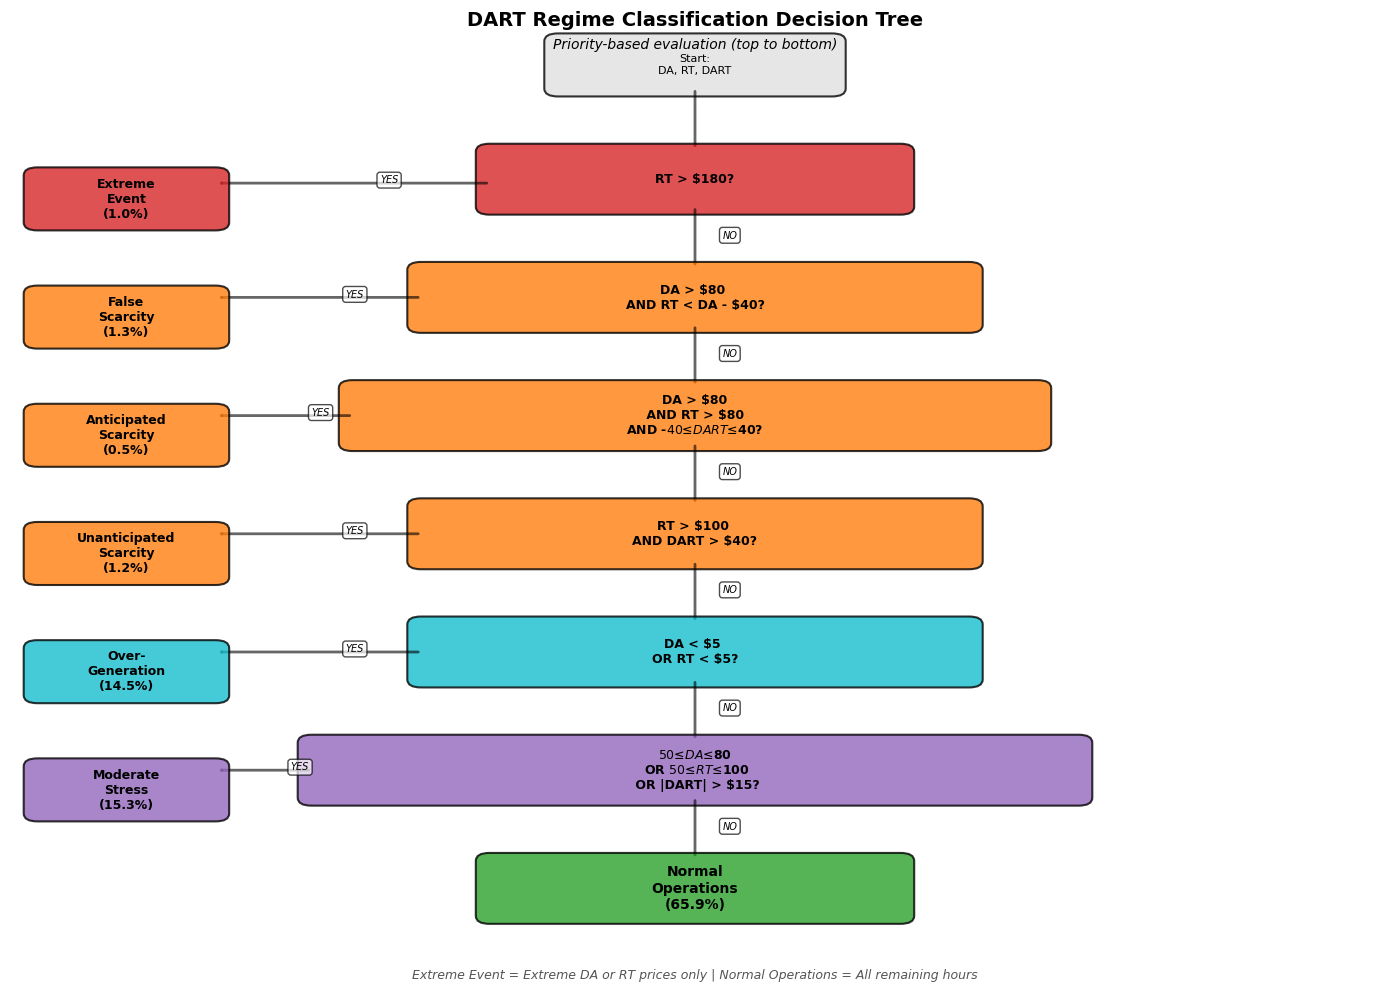

In [10]:
fig, ax = plt.subplots(figsize=(14, 10))
ax.set_xlim(0, 10)
ax.set_ylim(0, 12)
ax.axis('off')

# Color scheme
colors = {
    'extreme': '#d62728',
    'scarcity': '#ff7f0e',
    'normal': '#2ca02c',
    'stress': '#9467bd',
    'overgen': '#17becf'
}

# Helper function for boxes with better text handling
def add_box(ax, x, y, width, height, text, color, fontsize=9, bold=True):
    box = FancyBboxPatch((x, y), width, height, 
                         boxstyle="round,pad=0.1", 
                         edgecolor='black', facecolor=color, 
                         linewidth=1.5, alpha=0.8)
    ax.add_patch(box)
    weight = 'bold' if bold else 'normal'
    ax.text(x + width/2, y + height/2, text, 
            ha='center', va='center', fontsize=fontsize, 
            weight=weight, multialignment='center')

# Helper function for arrows
def add_arrow(ax, x1, y1, x2, y2, label='', style='->'):
    arrow = FancyArrowPatch((x1, y1), (x2, y2),
                           arrowstyle=style, lw=2, 
                           color='black', alpha=0.6)
    ax.add_patch(arrow)
    if label:
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        ax.text(mid_x + 0.2, mid_y, label, fontsize=7, 
                style='italic', bbox=dict(boxstyle='round', 
                facecolor='white', alpha=0.7))

# Start node
add_box(ax, 4, 11, 2, 0.6, 'Start:\nDA, RT, DART', '#e0e0e0', 8, bold=False)

# Level 1: Extreme check (RT only)
add_arrow(ax, 5, 11, 5, 10.2)
add_box(ax, 3.5, 9.5, 3, 0.7, 'RT > $180?', colors['extreme'], 9)
add_arrow(ax, 3.5, 9.8, 1.5, 9.8, 'YES')
add_box(ax, 0.2, 9.3, 1.3, 0.6, 'Extreme\nEvent\n(1.0%)', colors['extreme'], 9)

add_arrow(ax, 5, 9.5, 5, 8.7, 'NO')

# Level 2: False Scarcity
add_box(ax, 3, 8, 4, 0.7, 'DA > $80 \nAND RT < DA - $40?', colors['scarcity'], 9)
add_arrow(ax, 3, 8.35, 1.5, 8.35, 'YES')
add_box(ax, 0.2, 7.8, 1.3, 0.6, 'False\nScarcity\n(1.3%)', colors['scarcity'], 9)

add_arrow(ax, 5, 8, 5, 7.2, 'NO')

# Level 3: Anticipated Scarcity
add_box(ax, 2.5, 6.5, 5, 0.7, 'DA > $80\n AND RT > $80 \nAND -$40 ≤ DART ≤ $40?', colors['scarcity'], 9)
add_arrow(ax, 2.5, 6.85, 1.5, 6.85, 'YES')
add_box(ax, 0.2, 6.3, 1.3, 0.6, 'Anticipated\nScarcity\n(0.5%)', colors['scarcity'], 9)

add_arrow(ax, 5, 6.5, 5, 5.7, 'NO')

# Level 4: Unanticipated Scarcity
add_box(ax, 3, 5, 4, 0.7, 'RT > $100 \nAND DART > $40?', colors['scarcity'], 9)
add_arrow(ax, 3, 5.35, 1.5, 5.35, 'YES')
add_box(ax, 0.2, 4.8, 1.3, 0.6, 'Unanticipated\nScarcity\n(1.2%)', colors['scarcity'], 9)

add_arrow(ax, 5, 5, 5, 4.2, 'NO')

# Level 5: Over-Generation
add_box(ax, 3, 3.5, 4, 0.7, 'DA < $5 \nOR RT < $5?', colors['overgen'], 9)
add_arrow(ax, 3, 3.85, 1.5, 3.85, 'YES')
add_box(ax, 0.2, 3.3, 1.3, 0.6, 'Over-\nGeneration\n(14.5%)', colors['overgen'], 9)

add_arrow(ax, 5, 3.5, 5, 2.7, 'NO')

# Level 6: Moderate Stress
add_box(ax, 2.2, 2, 5.6, 0.7, '$50 ≤ DA ≤ $80\n OR $50 ≤ RT ≤ $100\n OR |DART| > $15?', colors['stress'], 9)
add_arrow(ax, 2.2, 2.35, 1.5, 2.35, 'YES')
add_box(ax, 0.2, 1.8, 1.3, 0.6, 'Moderate\nStress\n(15.3%)', colors['stress'], 9)

add_arrow(ax, 5, 2, 5, 1.2, 'NO')

# Level 7: Normal Operations (catch-all)
add_box(ax, 3.5, 0.5, 3, 0.7, 'Normal\nOperations\n(65.9%)', colors['normal'], 10)

# Title
ax.text(5, 11.8, 'DART Regime Classification Decision Tree', 
        ha='center', fontsize=14, weight='bold')
ax.text(5, 11.5, 'Priority-based evaluation (top to bottom)', 
        ha='center', fontsize=10, style='italic')

# Add footnote
ax.text(5, -0.3, 'Extreme Event = Extreme DA or RT prices only | Normal Operations = All remaining hours', 
        ha='center', fontsize=9, style='italic', color='#555555')

plt.tight_layout()
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'regime_decision_tree.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


In [11]:
def add_regime_features(df):
    """
    Add multiple regime duration features:
    - consecutive_regime_hours: hours in current regime
    - hours_since_last_extreme: hours since last Extreme Event
    - hours_since_any_scarcity: hours since any scarcity regime
    """
    df = df.sort_values(['node', 'start_time'])

    # Consecutive hours in current regime
    df['regime_change'] = df.groupby('node')['regime'].shift(1) != df['regime']
    df['regime_block'] = df.groupby('node')['regime_change'].cumsum()
    df['consecutive_regime_hours'] = df.groupby(['node', 'regime_block']).cumcount() + 1

    # Hours since last extreme event (by node)
    df['is_extreme'] = (df['regime'] == 'Extreme Event').astype(int)
    df['extreme_block'] = df.groupby('node')['is_extreme'].cumsum()
    df['hours_since_extreme'] = df.groupby(['node', 'extreme_block']).cumcount()
    df.loc[df['is_extreme'] == 1, 'hours_since_extreme'] = 0

    # Hours since any scarcity regime
    scarcity_regimes = ['Extreme Event', 'False Scarcity', 
                        'Anticipated Scarcity', 'Unanticipated Scarcity']
    df['is_scarcity'] = df['regime'].isin(scarcity_regimes).astype(int)
    df['scarcity_block'] = df.groupby('node')['is_scarcity'].cumsum()
    df['hours_since_scarcity'] = df.groupby(['node', 'scarcity_block']).cumcount()
    df.loc[df['is_scarcity'] == 1, 'hours_since_scarcity'] = 0

    # Clean up intermediate columns
    df = df.drop(columns=['regime_change', 'regime_block', 'is_extreme', 
                          'extreme_block', 'is_scarcity', 'scarcity_block'])

    return df

merged_pdf = add_regime_features(merged_pdf)

In [12]:
# How long do regimes typically last?
regime_duration_stats = merged_pdf.groupby(['node', 'regime']).agg(
    avg_duration=('consecutive_regime_hours', 'mean'),
    max_duration=('consecutive_regime_hours', 'max'),
    median_duration=('consecutive_regime_hours', 'median')
).reset_index()

print("\nRegime duration by node:")
print(regime_duration_stats.pivot(index='node', 
                                   columns='regime', 
                                   values='avg_duration').round(1))

# Find longest regime events
print("\nLongest regime events:")
longest_events = merged_pdf.loc[
    merged_pdf.groupby(['node', 'regime'])['consecutive_regime_hours'].idxmax()
]
print(longest_events[['node', 'regime', 'start_time', 
                      'consecutive_regime_hours']].sort_values(
                          'consecutive_regime_hours', ascending=False).head(10))



Regime duration by node:
regime          Anticipated Scarcity  Extreme Event  False Scarcity  \
node                                                                  
GRE.ALTW.ENDVI                   1.6            3.9             5.1   
GRE.AZ                           1.6            3.6             4.6   
GRE.LKFLGR1                      1.6            3.9             5.5   
GRE.REC.CC1_DC                   1.5            2.1             6.4   
GRE.SMP.GRE                      1.7            3.6             4.5   
MDU.GRE.EMMLOG                   1.4            3.6             5.1   
MINN.HUB                         1.7            3.6             4.8   
NSP.GRE.BFRDG                    1.5            4.2             6.0   
OTP.GRE.ASHTII                   1.8            3.5             4.6   
OTP.GRE.DEUEL                    1.5            4.1             6.1   
OTP.GREM_2.AZ                    2.2            3.3             4.7   
WAUE                             1.7            6.8

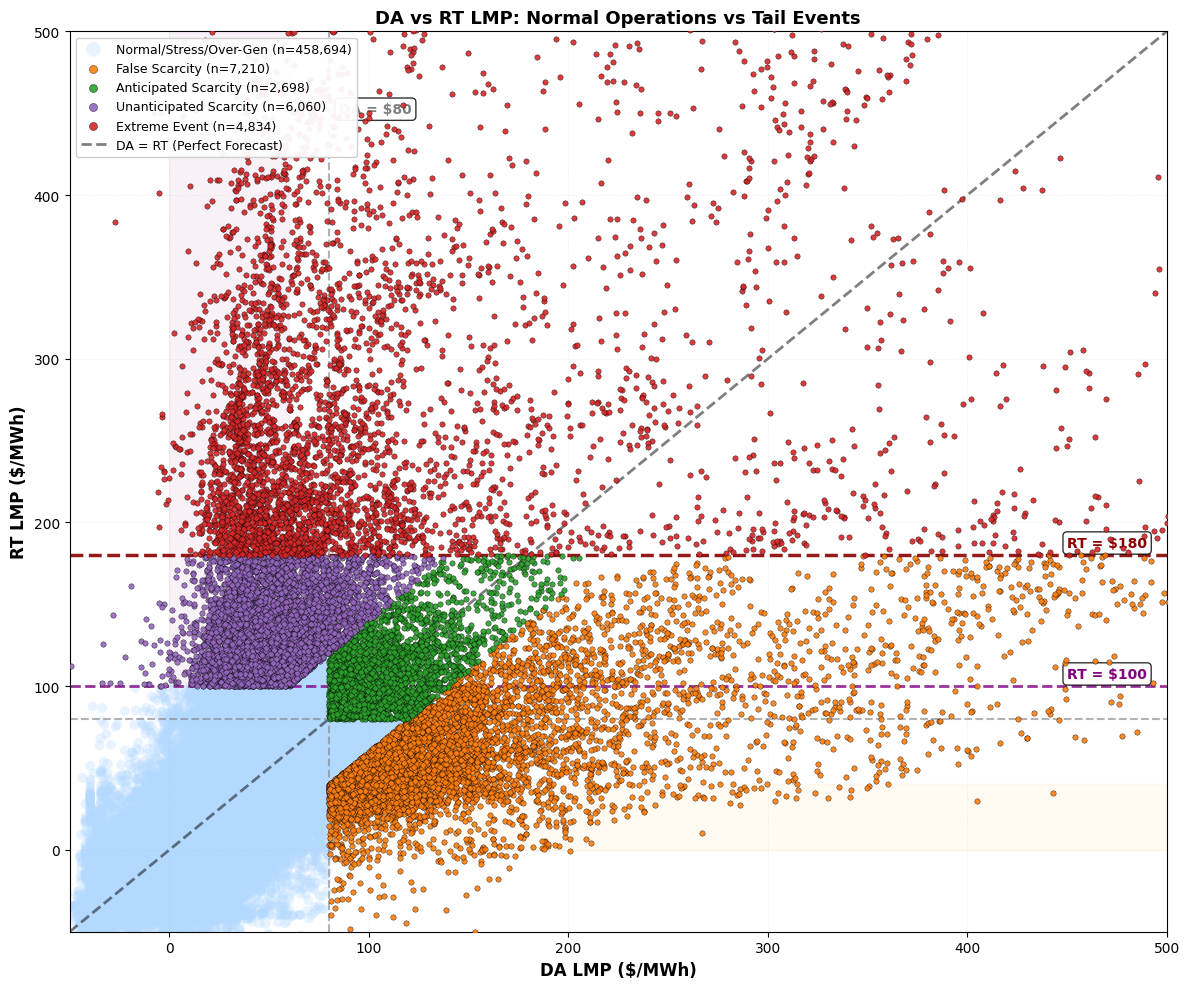

In [13]:
# Hybrid Scatter Plot: Normal vs Tail Events
fig, ax = plt.subplots(figsize=(12, 10))

# Separate datasets
normal_data = merged_pdf[merged_pdf['regime'].isin(['Normal Operations', 'Moderate Stress', 'Over-Generation'])]
tail_data = merged_pdf[merged_pdf['regime'].isin(['False Scarcity', 'Anticipated Scarcity', 
                                                   'Unanticipated Scarcity', 'Extreme Event'])]

# Plot normal operations as larger background dots
ax.scatter(normal_data['lmp_da_exante'], 
          normal_data['lmp_rt_expost'],
          c='#b3d9ff',  # Light blue
          alpha=0.3,
          s=50,  # Bigger dots
          label=f'Normal/Stress/Over-Gen (n={len(normal_data):,})',
          edgecolors='none')

# Overlay tail events with distinct colors and smaller dots
regime_colors = {
    'False Scarcity': '#ff7f0e',      # Orange
    'Anticipated Scarcity': '#2ca02c', # Green
    'Unanticipated Scarcity': '#9467bd', # Purple
    'Extreme Event': '#d62728'        # Red
}

for regime, color in regime_colors.items():
    regime_data = tail_data[tail_data['regime'] == regime]
    ax.scatter(regime_data['lmp_da_exante'], 
              regime_data['lmp_rt_expost'],
              c=color, 
              label=f'{regime} (n={len(regime_data):,})', 
              alpha=0.9, 
              s=15,  # Smaller than normal
              edgecolors='black',
              linewidths=0.3,
              zorder=5)  # Put on top

# Add 45-degree line (perfect forecast)
ax.plot([-50, 500], [-50, 500], 'k--', linewidth=2, alpha=0.5, label='DA = RT (Perfect Forecast)')

# Add regime boundaries
ax.axhline(y=180, color='darkred', linestyle='--', linewidth=2.5, alpha=0.9)
## add text label for RT = 180
ax.text(450, 185, 'RT = $180', fontsize=10, weight='bold', color='darkred', 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.axhline(y=100, color='purple', linestyle='--', linewidth=2, alpha=0.8)
ax.text(450, 105, 'RT = $100', fontsize=10, weight='bold', color='purple',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.axhline(y=80, color='gray', linestyle='--', linewidth=1.5, alpha=0.6)
ax.axvline(x=80, color='gray', linestyle='--', linewidth=1.5, alpha=0.6)
ax.text(85, 450, 'DA = $80', fontsize=10, weight='bold', color='gray',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Shade key regime regions lightly
ax.fill_between([80, 500], 0, 40, alpha=0.05, color='orange', label='_False Scarcity Zone')
ax.fill_between([0, 60], 100, 500, alpha=0.05, color='purple', label='_Unanticipated Zone')

# Labels and formatting
ax.set_xlabel('DA LMP ($/MWh)', fontsize=12, weight='bold')
ax.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax.set_title('DA vs RT LMP: Normal Operations vs Tail Events', 
             fontsize=13, weight='bold')
ax.set_xlim(-50, 500)
ax.set_ylim(-50, 500)
ax.grid(alpha=0.3, linestyle=':', linewidth=0.5)
ax.legend(loc='upper left', fontsize=9, framealpha=0.95, markerscale=1.5)

plt.tight_layout()
plt.savefig(PLOT_DIR / 'da_rt_regime_scatter.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
## read weather data for KMSP weather station parquet files
weather_files = list((DATA_DIR / "weather_kmsp").rglob("*.parquet"))
weather_df = pl.scan_parquet(weather_files)
print(f"KMSP Weather Data: {weather_df.collect().shape[0]:,} rows")
## select relevant weather features and convert datetime to proper format
weather_df = weather_df.select([
    pl.col("timestamp").alias("Datetime"),
    pl.col("temperature_2m").alias("Temperature"),
    pl.col("wind_speed_10m").alias("WindSpeed")
])
## convert Datetime to proper format
weather_df = weather_df.with_columns(
    pl.col("Datetime").cast(pl.Datetime("ns"))
)
## convert time from UTC to EST (MISO local time)
weather_df = weather_df.with_columns(
    pl.col("Datetime").dt.replace_time_zone("UTC").dt.convert_time_zone("America/New_York")
    ## convert back to naive datetime
    .dt.replace_time_zone(None).alias("Datetime")
)
## sort by Datetime
weather_df = weather_df.sort("Datetime")
## feature engineering: wind speed volatility (rolling std dev over 6 hours)
weather_df = weather_df.with_columns(
    pl.col("WindSpeed").rolling_std(window_size=6, min_periods=1).alias("WindSpeedVolatility6h")
)
## temperature buckets (fahrenheit)
weather_df = weather_df.with_columns(
    pl.when(pl.col("Temperature") <= -5).then(pl.lit("Extreme Cold"))
    .when((pl.col("Temperature") > -5) & (pl.col("Temperature") <= 10)).then(pl.lit("Very Cold"))
    .when((pl.col("Temperature") > 10) & (pl.col("Temperature") <= 32)).then(pl.lit("Cold"))
    .when((pl.col("Temperature") > 32) & (pl.col("Temperature") <= 50)).then(pl.lit("Cool"))
    .when((pl.col("Temperature") > 50) & (pl.col("Temperature") <= 70)).then(pl.lit("Mild"))
    .when((pl.col("Temperature") > 70) & (pl.col("Temperature") <= 85)).then(pl.lit("Hot"))
    .otherwise(pl.lit("Extreme Hot"))
    .alias("TemperatureBucket")
)

weather_df.collect().head()

KMSP Weather Data: 220,680 rows


C:\Users\legion\AppData\Local\Temp\ipykernel_3720\2559782991.py:25: DeprecationWarning: the argument `min_periods` for `Expr.rolling_std` is deprecated. It was renamed to `min_samples` in version 1.21.0.
  pl.col("WindSpeed").rolling_std(window_size=6, min_periods=1).alias("WindSpeedVolatility6h")


Datetime,Temperature,WindSpeed,WindSpeedVolatility6h,TemperatureBucket
datetime[ns],f64,f64,f64,str
2000-11-30 19:00:00,29.6,6.3,null,"""Cold"""
2000-11-30 20:00:00,29.1,6.3,0.0,"""Cold"""
2000-11-30 21:00:00,28.8,6.5,0.11547,"""Cold"""
2000-11-30 22:00:00,28.5,6.7,0.191485,"""Cold"""
2000-11-30 23:00:00,28.0,7.0,0.296648,"""Cold"""


In [15]:
## view min temperature for January 2026
weather_df.filter(
    (pl.col("Datetime").dt.year() == 2026) & (pl.col("Datetime").dt.month() == 1)
).select(pl.col("Temperature").min()).collect()

Temperature
f64
-22.8


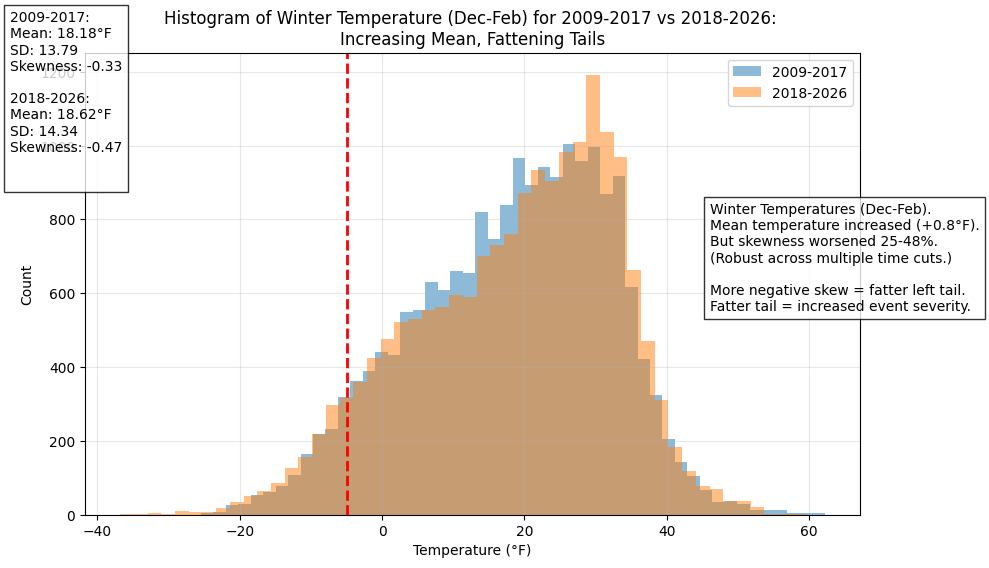

In [16]:
# Collect and filter data
weather_pdf = weather_df.collect().to_pandas()
weather_pdf = weather_pdf[weather_pdf['Datetime'].dt.month.isin([12, 1, 2])]
## filter to years 2009-2026
weather_pdf = weather_pdf[(weather_pdf['Datetime'].dt.year >= 2009) & (weather_pdf['Datetime'].dt.year <= 2026)]
weather_pdf['Period'] = weather_pdf['Datetime'].dt.year.apply(
    lambda x: '2009-2017' if x <= 2017 else '2018-2026'
)

## calculate mean, sd, skewness, kurtosis for each period
summary_stats = weather_pdf.groupby('Period')['Temperature'].agg(
    mean_temp=('mean'),
    sd_temp=('std'),
    skewness_temp=('skew'),
    kurtosis_temp=lambda x: stats.kurtosis(x)
).reset_index()

## calculate frequency of extreme cold days (< -5°F) for each period

# Create histogram
plt.figure(figsize=(10, 6))

# Plot each period with transparency
for period, color in zip(['2009-2017', '2018-2026'], ['#1f77b4', '#ff7f0e']):
    temps = weather_pdf[weather_pdf['Period'] == period]['Temperature']
    plt.hist(temps, bins=50, alpha=0.5, label=period, color=color)

plt.xlabel('Temperature (°F)')
plt.ylabel('Count')
## title with subtitle
plt.title('Histogram of Winter Temperature (Dec-Feb) for 2009-2017 vs 2018-2026: \nIncreasing Mean, Fattening Tails')
plt.legend()
plt.grid(alpha=0.3)
## add line for -5°F (extreme cold threshold)
plt.axvline(x=-5, color='red', linestyle='--', linewidth=2)
## add previously calculated summary stats as text box
## move to upper left corner
stats_text = ""
for _, row in summary_stats.iterrows():
    stats_text += (f"{row['Period']}:\n"
                   f"Mean: {row['mean_temp']:.2f}°F\n"
                   f"SD: {row['sd_temp']:.2f}\n"
                   f"Skewness: {row['skewness_temp']:.2f}\n\n")
                  # f"Kurtosis: {row['kurtosis_temp']:.2f}\n\n")
plt.gcf().text(0.05, 0.95, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
# Simpler stats box:
stats_text = (f"Winter Temperatures (Dec-Feb).\n"
              f"Mean temperature increased (+0.8°F).\n"
              f"But skewness worsened 25-48%.\n"
              f"(Robust across multiple time cuts.)\n\n"
              f"More negative skew = fatter left tail.\n"
              f"Fatter tail = increased event severity.")
## add stats box to middle right
plt.gcf().text(0.75, 0.45, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'winter_temperature_histogram.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


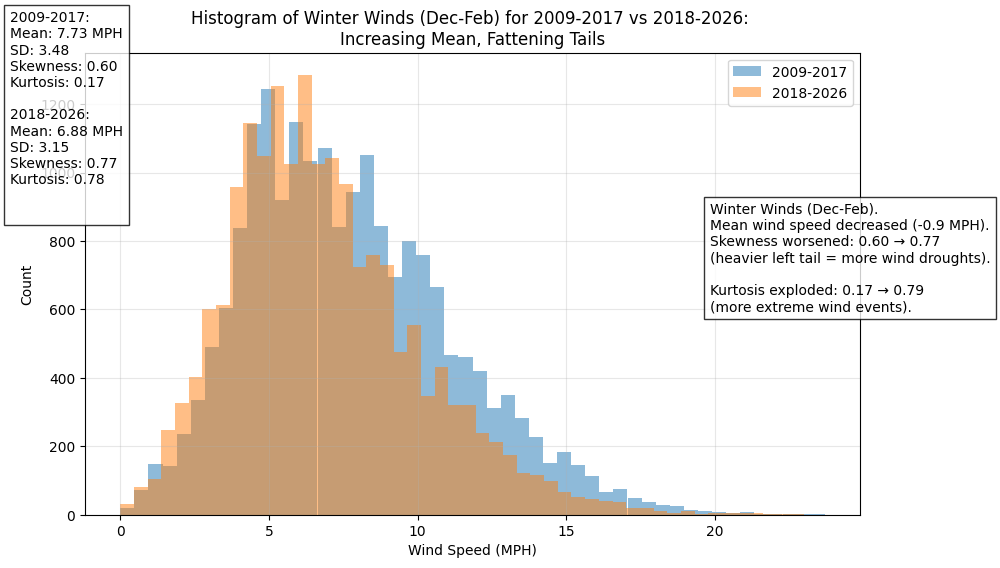

In [17]:
## histogram of wind distribution during winter season
## calculate mean, sd, skewness, kurtosis for each period
summary_stats = weather_pdf.groupby('Period')['WindSpeed'].agg(
    mean_wind=('mean'),
    sd_wind=('std'),
    skewness_wind=('skew'),
    kurtosis_wind=lambda x: stats.kurtosis(x)
).reset_index()

# Create histogram
plt.figure(figsize=(10, 6))

# Plot each period with transparency
for period, color in zip(['2009-2017', '2018-2026'], ['#1f77b4', '#ff7f0e']):
    temps = weather_pdf[weather_pdf['Period'] == period]['WindSpeed']
    plt.hist(temps, bins=50, alpha=0.5, label=period, color=color)

plt.xlabel('Wind Speed (MPH)')
plt.ylabel('Count')
## title with subtitle
plt.title('Histogram of Winter Winds (Dec-Feb) for 2009-2017 vs 2018-2026: \nIncreasing Mean, Fattening Tails')
plt.legend()
plt.grid(alpha=0.3)
## add previously calculated summary stats as text box
## move to upper left corner
## add previously calculated summary stats as text box
stats_text = ""
for _, row in summary_stats.iterrows():
    stats_text += (f"{row['Period']}:\n"
                   f"Mean: {row['mean_wind']:.2f} MPH\n"
                   f"SD: {row['sd_wind']:.2f}\n"
                   f"Skewness: {row['skewness_wind']:.2f}\n"
                   f"Kurtosis: {row['kurtosis_wind']:.2f}\n\n")
plt.gcf().text(0.05, 0.95, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8), verticalalignment='top')
# Simpler stats box:
stats_text = (f"Winter Winds (Dec-Feb).\n"
              f"Mean wind speed decreased (-0.9 MPH).\n"
              f"Skewness worsened: 0.60 → 0.77\n"
              f"(heavier left tail = more wind droughts).\n\n"
              f"Kurtosis exploded: 0.17 → 0.79\n"
              f"(more extreme wind events).")
## add stats box to middle right
plt.gcf().text(0.75, 0.45, stats_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'winter_winds_histogram.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


In [18]:
## merge weather data with merged_pdf on datetime
merged_pdf = merged_pdf.merge(
    weather_pdf.rename(columns={"Datetime": "start_time"}),
    on="start_time",
    how="left"
)
print(f"Merged DataFrame with Weather: {merged_pdf.shape[0]:,} rows")
merged_pdf.head()

Merged DataFrame with Weather: 479,496 rows


,node,start_time,lmp_da_exante,node_right,start_time_right,lmp_rt_expost,lmp_dart_spread,month,year,day_of_week,date,regime,consecutive_regime_hours,hours_since_extreme,hours_since_scarcity,Temperature,WindSpeed,WindSpeedVolatility6h,TemperatureBucket,Period
0,GRE.ALTW.ENDVI,2014-12-01 00:00:00,17.05,GRE.ALTW.ENDVI,2014-12-01 00:00:00,16.34,-0.71,12.0,2014.0,1.0,2014-12-01,Normal Operations,1.0,0.0,0.0,3.9,10.2,0.383406,Very Cold,2009-2017
1,GRE.ALTW.ENDVI,2014-12-01 01:00:00,17.87,GRE.ALTW.ENDVI,2014-12-01 01:00:00,18.40,0.53,12.0,2014.0,1.0,2014-12-01,Normal Operations,2.0,1.0,1.0,3.8,10.6,0.393277,Very Cold,2009-2017
2,GRE.ALTW.ENDVI,2014-12-01 02:00:00,17.87,GRE.ALTW.ENDVI,2014-12-01 02:00:00,18.04,0.17,12.0,2014.0,1.0,2014-12-01,Normal Operations,3.0,2.0,2.0,3.9,11.5,0.585377,Very Cold,2009-2017
3,GRE.ALTW.ENDVI,2014-12-01 03:00:00,17.07,GRE.ALTW.ENDVI,2014-12-01 03:00:00,20.00,2.93,12.0,2014.0,1.0,2014-12-01,Normal Operations,4.0,3.0,3.0,3.8,12.3,0.956556,Very Cold,2009-2017
4,GRE.ALTW.ENDVI,2014-12-01 04:00:00,19.53,GRE.ALTW.ENDVI,2014-12-01 04:00:00,21.24,1.71,12.0,2014.0,1.0,2014-12-01,Normal Operations,5.0,4.0,4.0,3.2,12.2,1.007307,Very Cold,2009-2017


In [19]:
## read in DA fuel mix 
da_mix_files = list((DATA_DIR / "miso_da_fuel_mix").rglob("*.parquet"))
da_fuel_df = pl.scan_parquet(da_mix_files)
print(f"DA Fuel Mix Data: {da_fuel_df.collect().shape[0]:,} rows")
## filter to region == "NORTH" only
da_fuel_df = da_fuel_df.filter(pl.col("region") == "NORTH")
## select relevant columns start_time, totalMw, coal, gas, wind, solar, nuclear
da_fuel_df = da_fuel_df.select([
    pl.col("start_time").alias("Datetime"),
    pl.col("totalMw").alias("TotalMW_DA"),
    pl.col("coal").alias("CoalMW_DA"),
    pl.col("gas").alias("GasMW_DA"),
    pl.col("wind").alias("WindMW_DA"),
    pl.col("solar").alias("SolarMW_DA"),
    pl.col("nuclear").alias("NuclearMW_DA")
])
## read in RT fuel mix
rt_mix_files = list((DATA_DIR / "miso_rt_fuel_mix").rglob("*.parquet"))
rt_fuel_df = pl.scan_parquet(rt_mix_files)
print(f"RT Fuel Mix Data: {rt_fuel_df.collect().shape[0]:,} rows")
## filter to region == "NORTH" only
rt_fuel_df = rt_fuel_df.filter(pl.col("region") == "NORTH")
## select relevant columns start_time, totalMw, coal, gas, wind, solar, nuclear
rt_fuel_df = rt_fuel_df.select([
    pl.col("start_time").alias("Datetime"),
    pl.col("totalMw").alias("TotalMW_RT"),
    pl.col("coal").alias("CoalMW_RT"),
    pl.col("gas").alias("GasMW_RT"),
    pl.col("wind").alias("WindMW_RT"),
    pl.col("solar").alias("SolarMW_RT"),
    pl.col("nuclear").alias("NuclearMW_RT")
])
## merge DA and RT fuel mix on Datetime
combined_fuel_df = da_fuel_df.join(
    rt_fuel_df,
    on="Datetime",
    how="inner"
).with_columns(
    ## calculate fuel mix differences
    (pl.col("TotalMW_RT") - pl.col("TotalMW_DA")).alias("TotalMW_Diff"),
    (pl.col("CoalMW_RT") - pl.col("CoalMW_DA")).alias("CoalMW_Diff"),
    (pl.col("GasMW_RT") - pl.col("GasMW_DA")).alias("GasMW_Diff"),
    (pl.col("WindMW_RT") - pl.col("WindMW_DA")).alias("WindMW_Diff"),
    (pl.col("SolarMW_RT") - pl.col("SolarMW_DA")).alias("SolarMW_Diff"),
    (pl.col("NuclearMW_RT") - pl.col("NuclearMW_DA")).alias("NuclearMW_Diff"),
    ## calculate percentage of RT vs DA
    ((pl.col("TotalMW_RT") / pl.col("TotalMW_DA"))).alias("TotalMW_PctDiff"),
    ((pl.col("CoalMW_RT") / pl.col("CoalMW_DA"))).alias("CoalMW_PctDiff"),
    ((pl.col("GasMW_RT") / pl.col("GasMW_DA"))).alias("GasMW_PctDiff"),
    ((pl.col("WindMW_RT") / pl.col("WindMW_DA"))).alias("WindMW_PctDiff"),
    ((pl.col("SolarMW_RT") / pl.col("SolarMW_DA"))).alias("SolarMW_PctDiff"),
    ((pl.col("NuclearMW_RT") / pl.col("NuclearMW_DA"))).alias("NuclearMW_PctDiff")
)
## flag low wind and low gas conditions based on less than 80% of DA forecast
combined_fuel_df = combined_fuel_df.with_columns(
    pl.when(pl.col("WindMW_PctDiff") <= 0.8)
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias("WindMissFlag"),
    pl.when(pl.col("GasMW_PctDiff") <= 0.8)
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias("GasMissFlag"),
    pl.when(pl.col("WindMW_RT") <= combined_fuel_df.select(pl.col("WindMW_RT").quantile(0.25)).collect()[0,0])
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias("LowWindFlag"),
    pl.when(pl.col("GasMW_RT") <= combined_fuel_df.select(pl.col("GasMW_RT").quantile(0.25)).collect()[0,0])
    .then(pl.lit(1))
    .otherwise(pl.lit(0))
    .alias("LowGasFlag")
)
## preview 
combined_fuel_df.collect().head()

DA Fuel Mix Data: 132,672 rows
RT Fuel Mix Data: 135,144 rows


Datetime,TotalMW_DA,CoalMW_DA,GasMW_DA,WindMW_DA,SolarMW_DA,NuclearMW_DA,TotalMW_RT,CoalMW_RT,GasMW_RT,WindMW_RT,SolarMW_RT,NuclearMW_RT,TotalMW_Diff,CoalMW_Diff,GasMW_Diff,WindMW_Diff,SolarMW_Diff,NuclearMW_Diff,TotalMW_PctDiff,CoalMW_PctDiff,GasMW_PctDiff,WindMW_PctDiff,SolarMW_PctDiff,NuclearMW_PctDiff,WindMissFlag,GasMissFlag,LowWindFlag,LowGasFlag
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i32,i32,i32,i32
2025-09-04 08:00:00,14401.4,5994.3,3062.2,2787.0,556.2,1798.0,13175.7,4710.0,2694.6,2913.4,840.0,1808.4,-1225.7,-1284.3,-367.6,126.4,283.8,10.4,0.91489,0.785746,0.879956,1.045353,1.510248,1.005784,0,0,1,0
2025-09-04 09:00:00,14654.1,6060.2,2812.8,2966.4,813.0,1798.0,13032.6,4489.5,2678.9,2647.6,1193.4,1806.4,-1621.5,-1570.7,-133.9,-318.8,380.4,8.4,0.889348,0.740817,0.952396,0.89253,1.467897,1.004672,0,0,1,0
2025-09-04 10:00:00,15324.4,5853.1,2786.5,3759.8,923.3,1798.0,13552.5,4514.8,2582.3,3324.0,1113.9,1803.8,-1771.9,-1338.3,-204.2,-435.8,190.6,5.8,0.884374,0.771352,0.926718,0.88409,1.206433,1.003226,0,0,1,0
2025-09-04 11:00:00,15798.6,5411.6,2711.5,4737.1,936.7,1798.0,15486.6,4595.6,2462.9,5383.4,1043.4,1806.2,-312.0,-816.0,-248.6,646.3,106.7,8.2,0.980251,0.849213,0.908316,1.136434,1.113911,1.004561,0,0,0,0
2025-09-04 12:00:00,16547.2,5190.4,2403.0,6020.5,931.6,1798.0,16981.1,4251.5,2222.0,7519.1,989.3,1806.4,433.9,-938.9,-181.0,1498.6,57.7,8.4,1.026222,0.819108,0.924677,1.248916,1.061936,1.004672,0,0,0,0


In [20]:
## merge combined fuel mix with weather and regime data
full_pdf = merged_pdf.merge(
    combined_fuel_df.collect().to_pandas().rename(columns={"Datetime": "start_time"}),
    on="start_time",
    how="left"
) 
full_pdf.head()

,node,start_time,lmp_da_exante,node_right,start_time_right,lmp_rt_expost,lmp_dart_spread,month,year,day_of_week,...,TotalMW_PctDiff,CoalMW_PctDiff,GasMW_PctDiff,WindMW_PctDiff,SolarMW_PctDiff,NuclearMW_PctDiff,WindMissFlag,GasMissFlag,LowWindFlag,LowGasFlag
0,GRE.ALTW.ENDVI,2014-12-01 00:00:00,17.05,GRE.ALTW.ENDVI,2014-12-01 00:00:00,16.34,-0.71,12.0,2014.0,1.0,...,1.072302,1.028210,0.978788,1.193290,1.466667,0.997448,0.0,0.0,0.0,1.0
1,GRE.ALTW.ENDVI,2014-12-01 01:00:00,17.87,GRE.ALTW.ENDVI,2014-12-01 01:00:00,18.40,0.53,12.0,2014.0,1.0,...,1.051034,0.999694,1.013904,1.177524,1.833333,0.980408,0.0,0.0,0.0,1.0
2,GRE.ALTW.ENDVI,2014-12-01 02:00:00,17.87,GRE.ALTW.ENDVI,2014-12-01 02:00:00,18.04,0.17,12.0,2014.0,1.0,...,1.043818,1.003665,1.206560,1.156237,1.400000,0.930283,0.0,0.0,0.0,1.0
3,GRE.ALTW.ENDVI,2014-12-01 03:00:00,17.07,GRE.ALTW.ENDVI,2014-12-01 03:00:00,20.00,2.93,12.0,2014.0,1.0,...,1.014555,1.015529,1.211297,1.058169,0.900000,0.890753,0.0,0.0,0.0,1.0
4,GRE.ALTW.ENDVI,2014-12-01 04:00:00,19.53,GRE.ALTW.ENDVI,2014-12-01 04:00:00,21.24,1.71,12.0,2014.0,1.0,...,1.005054,1.023526,1.413627,0.989435,1.400000,0.882147,0.0,0.0,0.0,1.0


In [21]:
## summary of regime by temperature bucket
## by frequency not count   
regime_temp_summary = full_pdf.groupby(['TemperatureBucket', 'regime']).size().reset_index(name='count')
flag_summary = pd.concat([
    full_pdf[full_pdf['LowWindFlag'] == 1].groupby('TemperatureBucket').size().reset_index(name='count').assign(regime='LowWindFlag'),
    full_pdf[full_pdf['LowGasFlag'] == 1].groupby('TemperatureBucket').size().reset_index(name='count').assign(regime='LowGasFlag'),
    full_pdf[full_pdf['WindMissFlag'] == 1].groupby('TemperatureBucket').size().reset_index(name='count').assign(regime='WindMissFlag'),
    full_pdf[full_pdf['GasMissFlag'] == 1].groupby('TemperatureBucket').size().reset_index(name='count').assign(regime='GasMissFlag')
], ignore_index=True)
regime_temp_summary = pd.concat([regime_temp_summary, flag_summary], ignore_index=True)
regime_temp_summary['frequency'] = regime_temp_summary.groupby('TemperatureBucket')['count'].transform(lambda x: (x / x.sum() * 100).round(2))
regime_temp_summary = regime_temp_summary.drop('count', axis=1).rename(columns={'frequency': 'count'})
regime_temp_summary = regime_temp_summary.pivot(index='TemperatureBucket', columns='regime', values='count').fillna(0)
regime_temp_summary = regime_temp_summary.reindex(columns=[
    'Extreme Event', 'False Scarcity', 'Anticipated Scarcity',  
    'Unanticipated Scarcity', 'Moderate Stress', 'Over-Generation', 'Normal Operations',
    ## flags for low wind and low gas
    'LowWindFlag', 'LowGasFlag', 'WindMissFlag', 'GasMissFlag'
])
regime_temp_summary

regime,Extreme Event,False Scarcity,Anticipated Scarcity,Unanticipated Scarcity,Moderate Stress,Over-Generation,Normal Operations,LowWindFlag,LowGasFlag,WindMissFlag,GasMissFlag
TemperatureBucket,,,,,,,,,,,
Cold,0.24,0.29,0.16,0.50,6.82,6.31,44.68,14.76,15.52,6.90,3.83
Cool,0.15,0.04,0.01,0.29,4.69,8.68,41.51,11.67,23.03,5.35,4.59
Extreme Cold,6.29,5.72,2.17,2.09,17.64,2.54,28.23,21.10,6.00,2.77,5.45
Mild,0.00,0.00,0.00,0.07,0.93,14.10,33.39,2.87,34.00,2.58,12.05
Very Cold,1.03,3.35,0.98,1.17,12.93,4.65,40.48,15.60,10.94,4.11,4.76


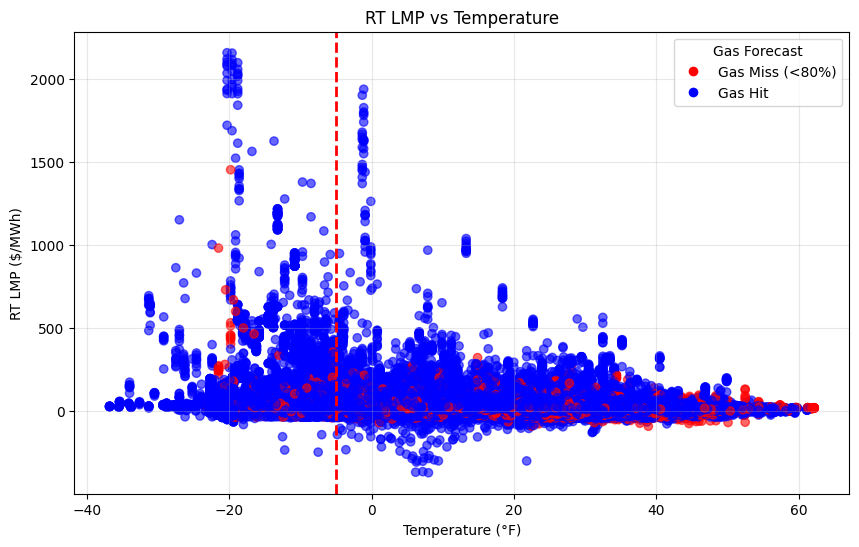

<Figure size 640x480 with 0 Axes>

In [22]:
## explore relationship between temperature and RT prices
## color by GasMissFlag (miss = 1, hit = 0)
full_pdf['GasMissFlag'] = full_pdf['GasMissFlag'].fillna(0)
## label GasMissFlag as 'Hit' and 'Miss'
full_pdf['GasMissLabel'] = full_pdf['GasMissFlag'].apply(lambda x: 'Miss' if x == 1 else 'Hit')

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    full_pdf['Temperature'], 
    full_pdf['lmp_rt_expost'], 
    c=full_pdf['GasMissLabel'].map({'Hit': 'blue', 'Miss': 'red'}),
    alpha=0.6
)
## add legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='Gas Miss (<80%)', markerfacecolor='red', markersize=8),
    plt.Line2D([0], [0], marker='o', color='w', label='Gas Hit', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=handles, title='Gas Forecast')

plt.xlabel('Temperature (°F)')
plt.ylabel('RT LMP ($/MWh)')
plt.title('RT LMP vs Temperature')
plt.grid(alpha=0.3)
plt.axvline(x=-5, color='red', linestyle='--', linewidth=2, label='Extreme Cold Threshold (-5°F)')
plt.show()
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'rt_lmp_vs_temperature_gasmissflag.png', dpi=300, bbox_inches='tight', 
            facecolor='white')

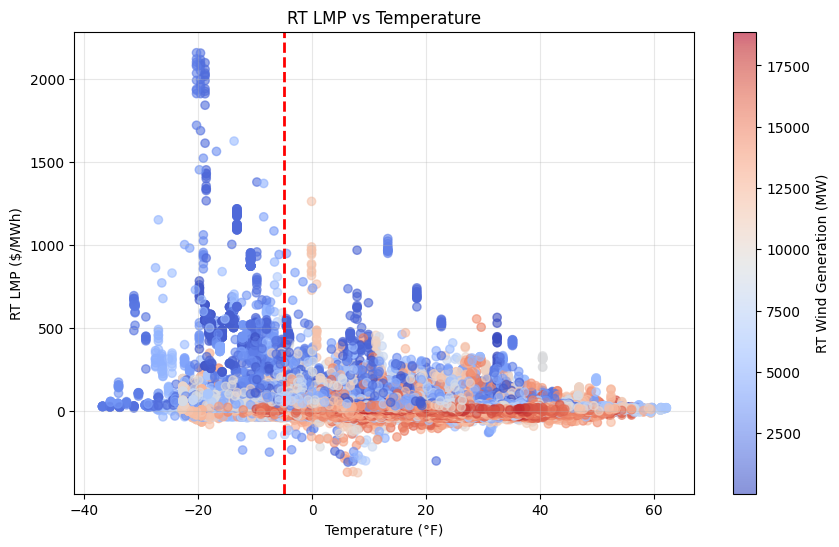

In [23]:
## explore relationship between temperature and RT prices

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    full_pdf['Temperature'], 
    full_pdf['lmp_rt_expost'], 
    ## color by wind generated in RT
    c=full_pdf['WindMW_RT'],
    ## color red for low wind, blue for high wind
    cmap='coolwarm',
    alpha=0.6
)
## colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('RT Wind Generation (MW)')

plt.xlabel('Temperature (°F)')
plt.ylabel('RT LMP ($/MWh)')
plt.title('RT LMP vs Temperature')
plt.grid(alpha=0.3)
plt.axvline(x=-5, color='red', linestyle='--', linewidth=2, label='Extreme Cold Threshold (-5°F)')
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'rt_lmp_vs_temperature_windmw_rt.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


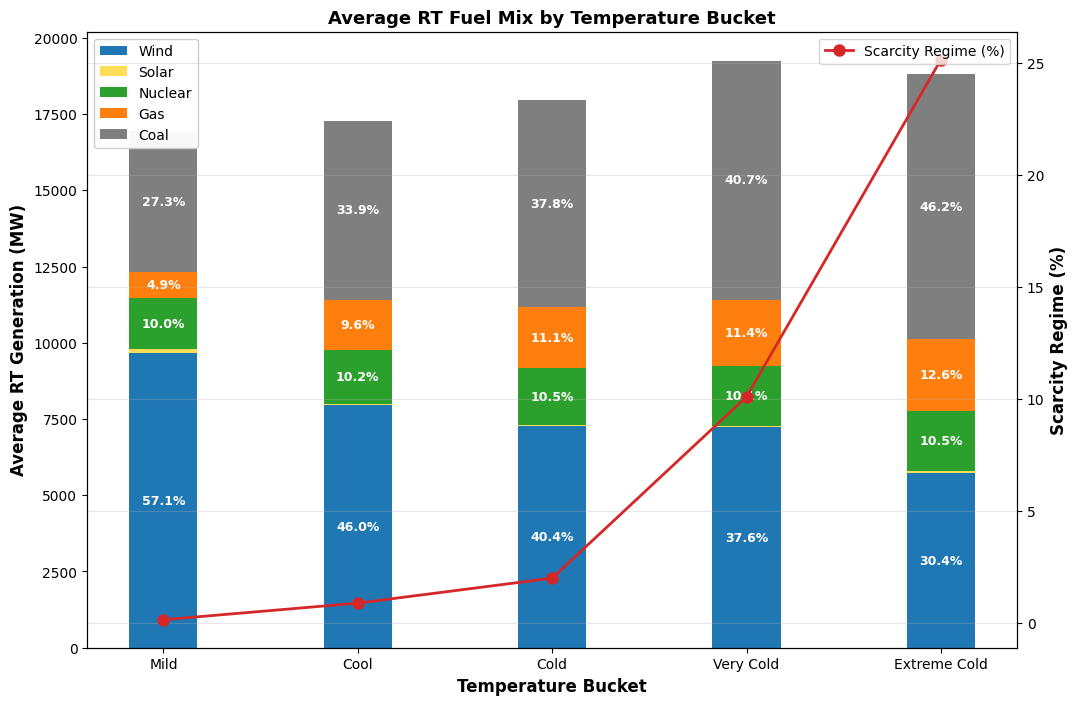

In [24]:
## visualize average fuel mix by temperature bucket 
fuel_mix_summary = full_pdf.groupby('TemperatureBucket').agg(
    avg_CoalMW_RT=('CoalMW_RT', 'mean'),
    avg_GasMW_RT=('GasMW_RT', 'mean'),
    avg_WindMW_RT=('WindMW_RT', 'mean'),
    avg_SolarMW_RT=('SolarMW_RT', 'mean'),
    avg_NuclearMW_RT=('NuclearMW_RT', 'mean')
).reset_index()
## calculate total average RT generation and percentage by fuel type
fuel_mix_summary['TotalAvgMW_RT'] = (fuel_mix_summary['avg_CoalMW_RT'] +
                                     fuel_mix_summary['avg_GasMW_RT'] + 
                                        fuel_mix_summary['avg_WindMW_RT'] +
                                        fuel_mix_summary['avg_SolarMW_RT'] +
                                        fuel_mix_summary['avg_NuclearMW_RT'])
fuel_mix_summary['CoalPct_RT'] = (fuel_mix_summary['avg_CoalMW_RT'] / fuel_mix_summary['TotalAvgMW_RT'] * 100).round(2)
fuel_mix_summary['GasPct_RT'] = (fuel_mix_summary['avg_GasMW_RT'] / fuel_mix_summary['TotalAvgMW_RT'] * 100).round(2)
fuel_mix_summary['WindPct_RT'] = (fuel_mix_summary['avg_WindMW_RT'] / fuel_mix_summary['TotalAvgMW_RT'] * 100).round(2)
fuel_mix_summary['SolarPct_RT'] = (fuel_mix_summary['avg_SolarMW_RT'] / fuel_mix_summary['TotalAvgMW_RT'] * 100).round(2)
fuel_mix_summary['NuclearPct_RT'] = (fuel_mix_summary['avg_NuclearMW_RT'] / fuel_mix_summary['TotalAvgMW_RT'] * 100).round(2)
# Sort temperature buckets
temp_order = ['Mild', 'Cool', 'Cold', 'Very Cold', 'Extreme Cold']
fuel_mix_summary['TemperatureBucket'] = pd.Categorical(fuel_mix_summary['TemperatureBucket'], categories=temp_order, ordered=True)
fuel_mix_summary = fuel_mix_summary.sort_values('TemperatureBucket')
# Create plot as stacked bar chart
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
x = np.arange(len(fuel_mix_summary['TemperatureBucket']))
bars_wind = ax.bar(x, fuel_mix_summary['avg_WindMW_RT'], 
                   width=bar_width, label='Wind', color='#1f77b4', align='center')
bars_solar = ax.bar(x, fuel_mix_summary['avg_SolarMW_RT'], 
                    width=bar_width, bottom=fuel_mix_summary['avg_WindMW_RT'], label='Solar', color='#ffdd57', align='center')
bars_nuclear = ax.bar(x, fuel_mix_summary['avg_NuclearMW_RT'], 
                      width=bar_width, bottom=fuel_mix_summary['avg_WindMW_RT'] + fuel_mix_summary['avg_SolarMW_RT'], 
                      label='Nuclear', color='#2ca02c', align='center')  
bars_gas = ax.bar(x, fuel_mix_summary['avg_GasMW_RT'], 
                  width=bar_width, bottom=fuel_mix_summary['avg_WindMW_RT'] + fuel_mix_summary['avg_SolarMW_RT'] + fuel_mix_summary['avg_NuclearMW_RT'], 
                  label='Gas', color='#ff7f0e', align='center')
bars_coal = ax.bar(x, fuel_mix_summary['avg_CoalMW_RT'], 
                   width=bar_width, 
                   bottom=fuel_mix_summary['avg_WindMW_RT'] + fuel_mix_summary['avg_SolarMW_RT'] + fuel_mix_summary['avg_NuclearMW_RT'] + fuel_mix_summary['avg_GasMW_RT'], 
                   label='Coal', color='#7f7f7f', align='center')
## annotate percentage labels on each bar segment (always show, skip solar - too small)
## sort fuel_mix_summary by TemperatureBucket to ensure correct order
fuel_mix_summary = fuel_mix_summary.sort_values('TemperatureBucket')
for idx, (i, row) in enumerate(fuel_mix_summary.iterrows()):
    # Wind
    if row['WindPct_RT'] > 2:  # Only show label if segment is tall enough
        ax.text(idx, row['avg_WindMW_RT'] / 2, 
                f"{row['WindPct_RT']:.1f}%",
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Nuclear
    if row['NuclearPct_RT'] > 2:  # Only show label if segment is tall enough
        ax.text(idx, row['avg_WindMW_RT'] + row['avg_SolarMW_RT'] + row['avg_NuclearMW_RT'] / 2, 
                f"{row['NuclearPct_RT']:.1f}%",
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Gas
    if row['GasPct_RT'] > 2:  # Only show label if segment is tall enough
        ax.text(idx, row['avg_WindMW_RT'] + row['avg_SolarMW_RT'] + row['avg_NuclearMW_RT'] + row['avg_GasMW_RT'] / 2, 
                f"{row['GasPct_RT']:.1f}%",
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')
    # Coal
    if row['CoalPct_RT'] > 2:  # Only show label if segment is tall enough
        ax.text(idx, row['avg_WindMW_RT'] + row['avg_SolarMW_RT'] + row['avg_NuclearMW_RT'] + row['avg_GasMW_RT'] + row['avg_CoalMW_RT'] / 2, 
                f"{row['CoalPct_RT']:.1f}%",
                ha='center', va='center', fontsize=9, fontweight='bold', color='white')

ax.set_xlabel('Temperature Bucket', fontsize=12, weight='bold')
ax.set_ylabel('Average RT Generation (MW)', fontsize=12, weight='bold')
ax.set_title('Average RT Fuel Mix by Temperature Bucket', fontsize=13, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(fuel_mix_summary['TemperatureBucket'])
ax.legend(loc='upper left', fontsize=10, framealpha=0.95)

# Add scarcity regime % on right y-axis
ax2 = ax.twinx()
scarcity_by_temp = full_pdf.groupby('TemperatureBucket')['regime'].apply(
    lambda x: (x.isin(['Extreme Event', 'False Scarcity', 'Anticipated Scarcity', 'Unanticipated Scarcity']).sum() / len(x) * 100)
)
# Explicitly filter fuel_mix_summary to build scarcity values in correct order
scarcity_values = []
for temp_bucket in fuel_mix_summary['TemperatureBucket']:
    scarcity_values.append(scarcity_by_temp.get(temp_bucket, 0))
ax2.plot(x, scarcity_values, 
         color='#d62728', marker='o', markersize=8, linewidth=2, label='Scarcity Regime (%)')
ax2.set_ylabel('Scarcity Regime (%)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)

plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'avg_rt_fuel_mix_by_temp_bucket.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


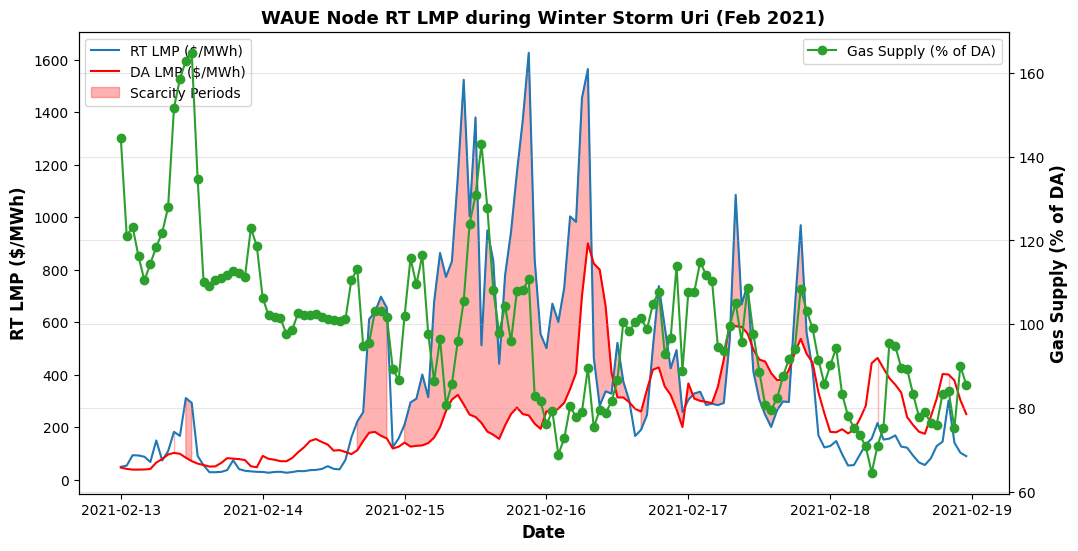

In [25]:
## visualize WAUE node during winter storm Uri period
## add gas miss pct on right y-axis
waue_pdf = full_pdf[full_pdf['node'] == 'WAUE']
waue_pdf = waue_pdf[(waue_pdf['start_time'] >= '2021-02-13') & (waue_pdf['start_time'] < '2021-02-19')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], waue_pdf['lmp_rt_expost'], 
                 where=((waue_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('WAUE Node RT LMP during Winter Storm Uri (Feb 2021)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add gas miss pct on right y-axis
ax2 = ax1.twinx()
ax2.plot(waue_pdf['start_time'], waue_pdf['GasMW_PctDiff'] * 100, color='#2ca02c', marker='o', label='Gas Supply (% of DA)')
ax2.set_ylabel('Gas Supply (% of DA)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'waue_rt_lmp_winter_storm_uri.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()

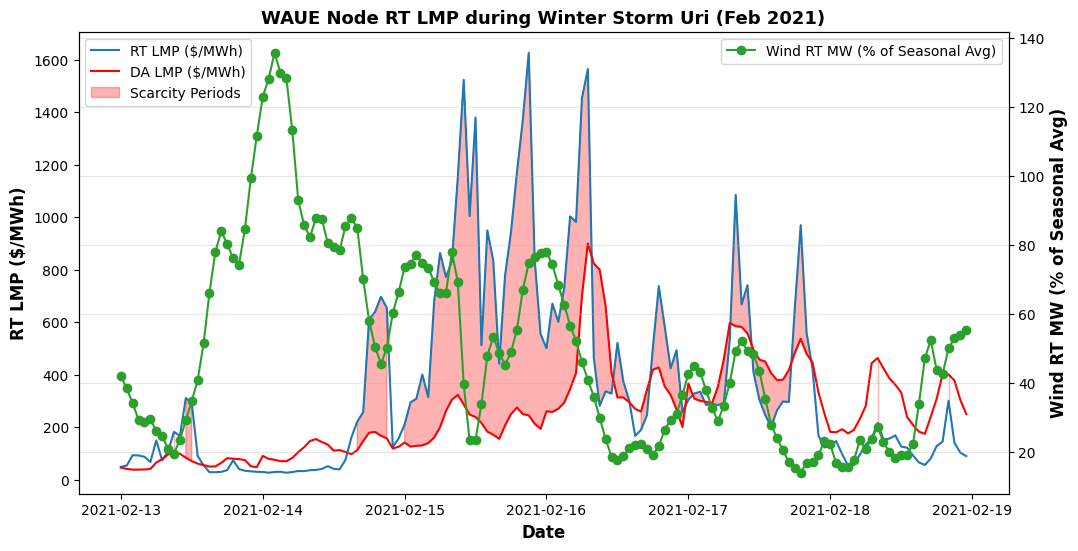

In [26]:
## calculate Wind RT MW as percentage of seasonal average of Wind RT MW (filtered to winter months only) just need value
seasonal_wind_avg = full_pdf[full_pdf['start_time'].dt.month.isin([12, 1, 2])]['WindMW_RT'].mean()
full_pdf['WindMW_RT_PctOfSeasonalAvg'] = (full_pdf['WindMW_RT'] / seasonal_wind_avg * 100).round(2)
## visualize WAUE node during winter storm Uri period
## add gas miss pct on right y-axis
waue_pdf = full_pdf[full_pdf['node'] == 'WAUE']
waue_pdf = waue_pdf[(waue_pdf['start_time'] >= '2021-02-13') & (waue_pdf['start_time'] < '2021-02-19')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], waue_pdf['lmp_rt_expost'], 
                 where=((waue_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('WAUE Node RT LMP during Winter Storm Uri (Feb 2021)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add wind RT MW pct of seasonal avg on right y-axis
ax2 = ax1.twinx()
ax2.plot(waue_pdf['start_time'], waue_pdf['WindMW_RT_PctOfSeasonalAvg'], color='#2ca02c', marker='o', label='Wind RT MW (% of Seasonal Avg)')
ax2.set_ylabel('Wind RT MW (% of Seasonal Avg)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'waue_rt_lmp_winter_storm_uri_wind_pct.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


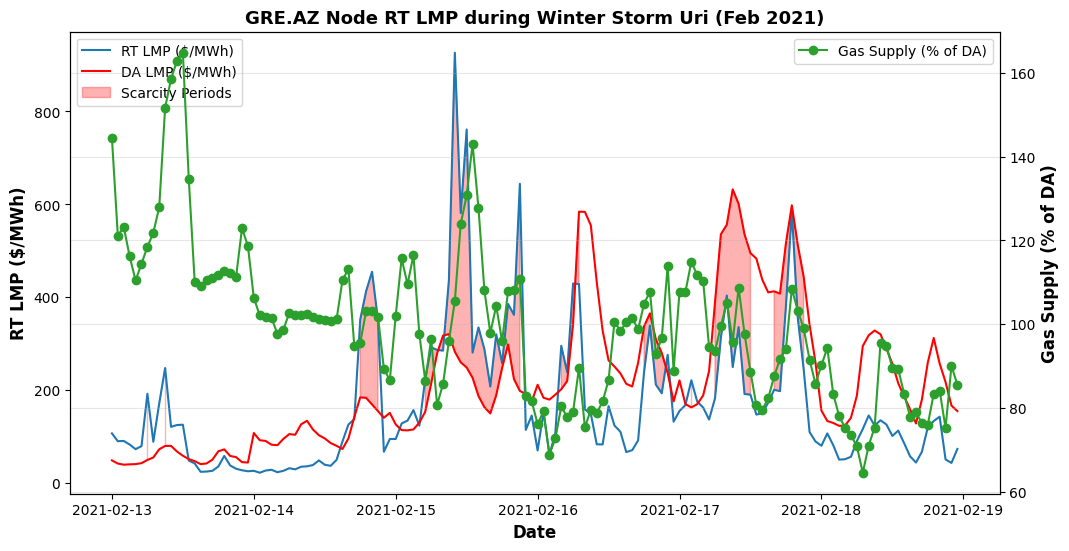

In [27]:
## visualize GRE.AZ node during winter storm Uri period
## add gas miss pct on right y-axis
gre_az_pdf = full_pdf[full_pdf['node'] == 'GRE.AZ']
gre_az_pdf = gre_az_pdf[(gre_az_pdf['start_time'] >= '2021-02-13') & (gre_az_pdf['start_time'] < '2021-02-19')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], gre_az_pdf['lmp_rt_expost'], 
                 where=((gre_az_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('GRE.AZ Node RT LMP during Winter Storm Uri (Feb 2021)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add gas miss pct on right y-axis
ax2 = ax1.twinx()
ax2.plot(gre_az_pdf['start_time'], gre_az_pdf['GasMW_PctDiff'] * 100, color='#2ca02c', marker='o', label='Gas Supply (% of DA)')
ax2.set_ylabel('Gas Supply (% of DA)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'gre_az_rt_lmp_winter_storm_uri.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


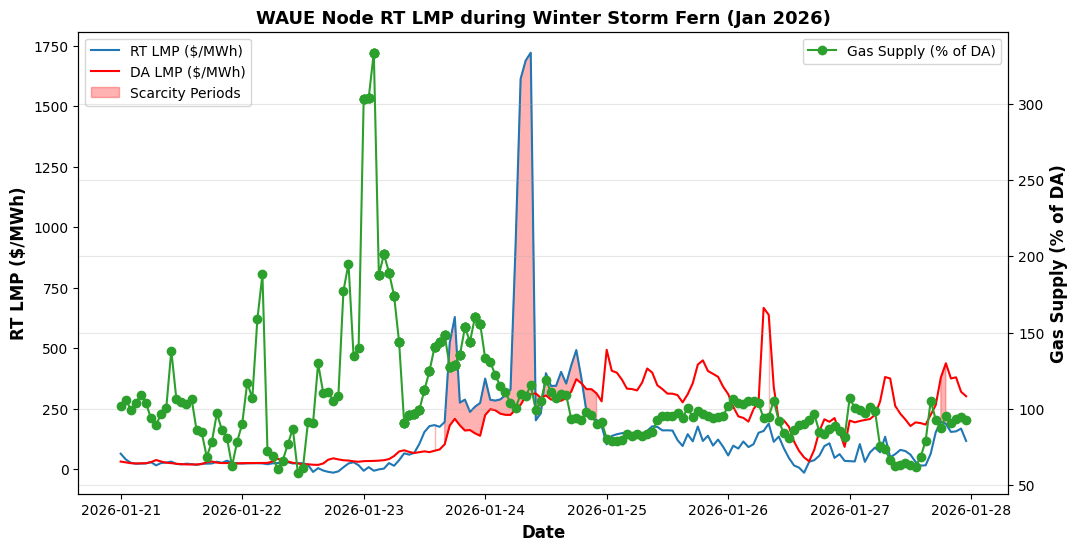

In [28]:
## visualize WAUE node during winter 2026 cold snap January 21 to 26, 2026
## add gas miss pct on right y-axis
waue_pdf = full_pdf[full_pdf['node'] == 'WAUE']
waue_pdf = waue_pdf[(waue_pdf['start_time'] >= '2026-01-21') & (waue_pdf['start_time'] < '2026-01-28')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], waue_pdf['lmp_rt_expost'], 
                 where=((waue_pdf['lmp_rt_expost'] > 180)),
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('WAUE Node RT LMP during Winter Storm Fern (Jan 2026)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add gas miss pct on right y-axis
ax2 = ax1.twinx()
ax2.plot(waue_pdf['start_time'], waue_pdf['GasMW_PctDiff'] * 100, color='#2ca02c', marker='o', label='Gas Supply (% of DA)')
ax2.set_ylabel('Gas Supply (% of DA)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'waue_rt_lmp_jan2026_cold_snap.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


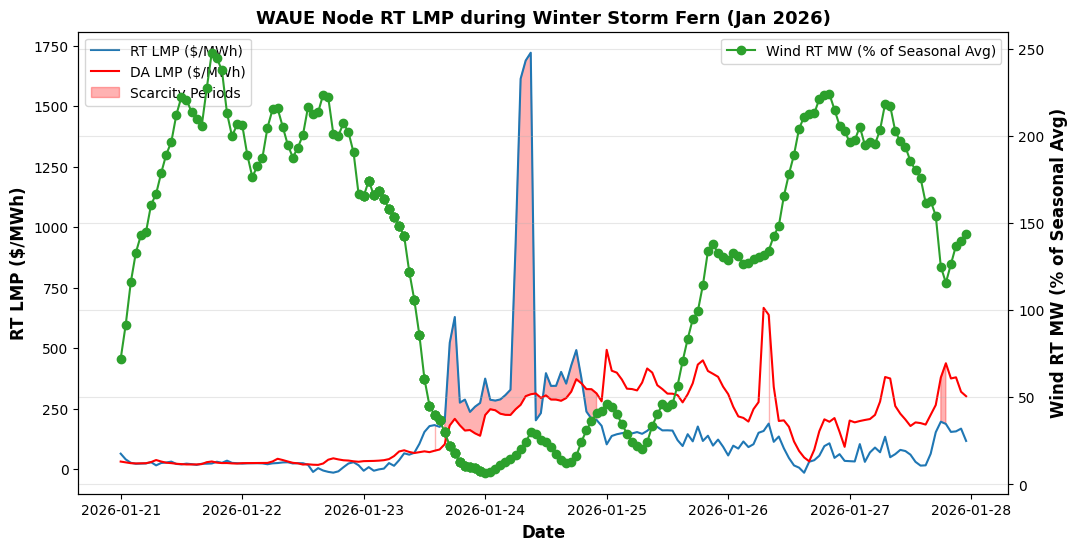

In [29]:
## visualize WAUE node during winter 2026 cold snap January 21 to 26, 2026
## add wind pct of seasonal avg on right y-axis
waue_pdf = full_pdf[full_pdf['node'] == 'WAUE']
waue_pdf = waue_pdf[(waue_pdf['start_time'] >= '2026-01-21') & (waue_pdf['start_time'] < '2026-01-28')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], waue_pdf['lmp_rt_expost'], 
                 where=((waue_pdf['lmp_rt_expost'] > 180)),
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('WAUE Node RT LMP during Winter Storm Fern (Jan 2026)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add wind pct of seasonal avg on right y-axis
ax2 = ax1.twinx()
ax2.plot(waue_pdf['start_time'], waue_pdf['WindMW_RT_PctOfSeasonalAvg'], color='#2ca02c', marker='o', label='Wind RT MW (% of Seasonal Avg)')
ax2.set_ylabel('Wind RT MW (% of Seasonal Avg)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'waue_rt_lmp_jan2026_cold_snap_wind_pct.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


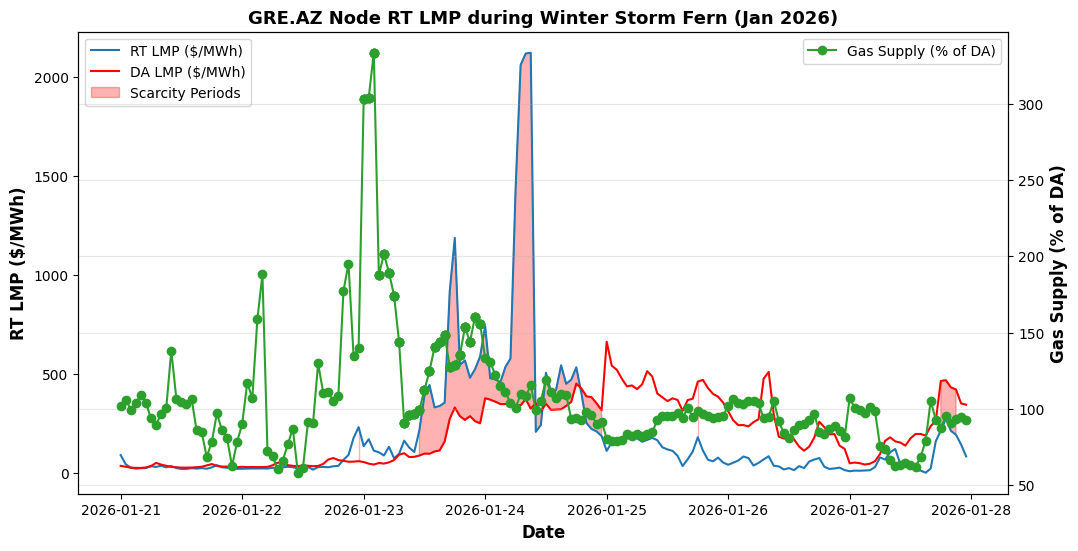

In [30]:
## visualize GRE.AZ node during january 2026 cold snap January 21 to 26, 2026
## add gas miss pct on right y-axis
gre_az_pdf = full_pdf[full_pdf['node'] == 'GRE.AZ']
gre_az_pdf = gre_az_pdf[(gre_az_pdf['start_time'] >= '2026-01-21') & (gre_az_pdf['start_time'] < '2026-01-28')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], gre_az_pdf['lmp_rt_expost'], 
                 where=((gre_az_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('GRE.AZ Node RT LMP during Winter Storm Fern (Jan 2026)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add gas miss pct on right y-axis
ax2 = ax1.twinx()
ax2.plot(gre_az_pdf['start_time'], gre_az_pdf['GasMW_PctDiff'] * 100, color='#2ca02c', marker='o', label='Gas Supply (% of DA)')
ax2.set_ylabel('Gas Supply (% of DA)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'gre_az_rt_lmp_jan2026_cold_snap.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


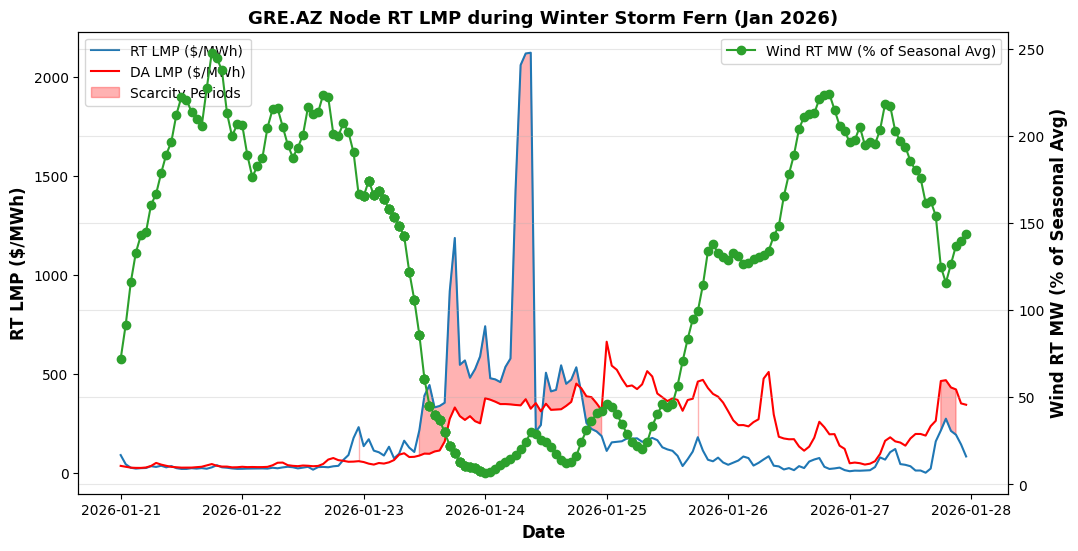

In [31]:
## visualize GRE.AZ node during january 2026 cold snap January 21 to 26, 2026
## add wind pct of seasonal avg on right y-axis
gre_az_pdf = full_pdf[full_pdf['node'] == 'GRE.AZ']
gre_az_pdf = gre_az_pdf[(gre_az_pdf['start_time'] >= '2026-01-21') & (gre_az_pdf['start_time'] < '2026-01-28')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], gre_az_pdf['lmp_rt_expost'], 
                 where=((gre_az_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('GRE.AZ Node RT LMP during Winter Storm Fern (Jan 2026)', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add wind pct of seasonal avg on right y-axis
ax2 = ax1.twinx()
ax2.plot(gre_az_pdf['start_time'], gre_az_pdf['WindMW_RT_PctOfSeasonalAvg'], color='#2ca02c', marker='o', label='Wind RT MW (% of Seasonal Avg)')
ax2.set_ylabel('Wind RT MW (% of Seasonal Avg)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'gre_az_rt_lmp_jan2026_cold_snap_wind_pct.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()


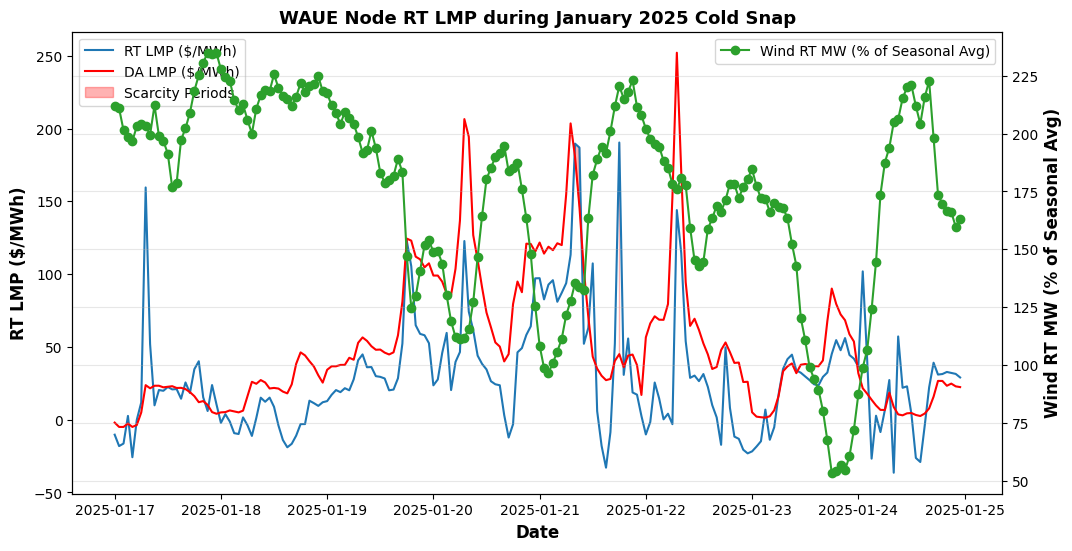

In [55]:
## visualize WAUE node during january 2025 cold snap January 17 to 24, 2025
## add wind pct of seasonal avg on right y-axis
waue_pdf = full_pdf[full_pdf['node'] == 'WAUE']
waue_pdf = waue_pdf[(waue_pdf['start_time'] >= '2025-01-17') & (waue_pdf['start_time'] < '2025-01-25')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(waue_pdf['start_time'], waue_pdf['lmp_da_exante'], waue_pdf['lmp_rt_expost'], 
                 where=((waue_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('WAUE Node RT LMP during January 2025 Cold Snap', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add wind pct of seasonal avg on right y-axis
ax2 = ax1.twinx()
ax2.plot(waue_pdf['start_time'], waue_pdf['WindMW_RT_PctOfSeasonalAvg'], color='#2ca02c', marker='o', label='Wind RT MW (% of Seasonal Avg)')
ax2.set_ylabel('Wind RT MW (% of Seasonal Avg)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'waue_rt_lmp_jan2025_cold_snap_wind_pct.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()

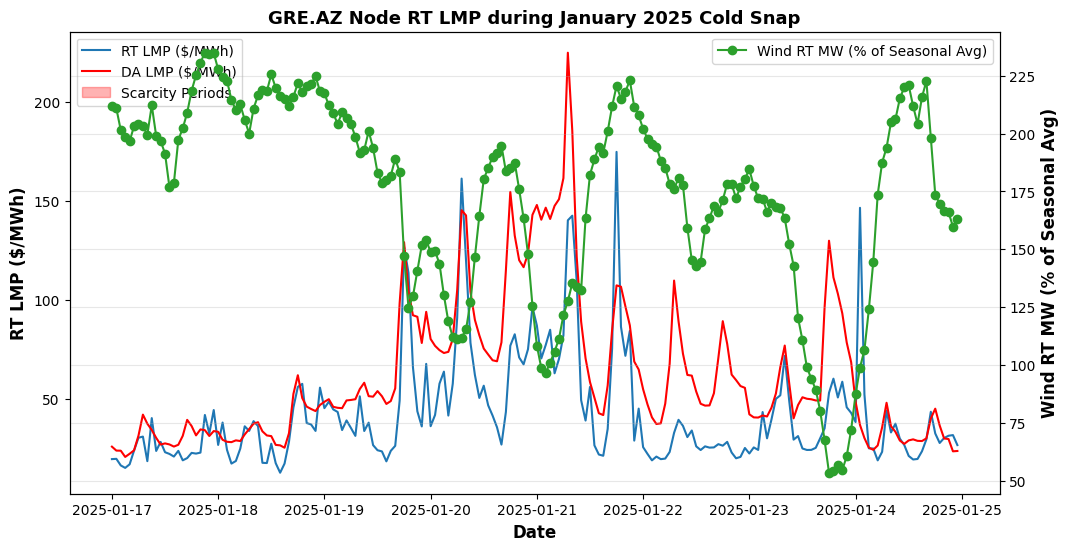

In [56]:
## visualize GRE.AZ node during january 2025 cold snap January 17 to 24, 2025
## add wind pct of seasonal avg on right y-axis
gre_az_pdf = full_pdf[full_pdf['node'] == 'GRE.AZ']
gre_az_pdf = gre_az_pdf[(gre_az_pdf['start_time'] >= '2025-01-17') & (gre_az_pdf['start_time'] < '2025-01-25')]
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_rt_expost'], color='#1f77b4', label='RT LMP ($/MWh)')
ax1.plot(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], color='red', label='DA LMP ($/MWh)')
## shade regime areas in between DA and RT prices
plt.fill_between(gre_az_pdf['start_time'], gre_az_pdf['lmp_da_exante'], gre_az_pdf['lmp_rt_expost'], 
                 where=((gre_az_pdf['lmp_rt_expost'] > 180)), 
                 color='red', alpha=0.3, label='Scarcity Periods')

ax1.set_xlabel('Date', fontsize=12, weight='bold')
ax1.set_ylabel('RT LMP ($/MWh)', fontsize=12, weight='bold')
ax1.set_title('GRE.AZ Node RT LMP during January 2025 Cold Snap', fontsize=13, weight='bold')
ax1.legend(loc='upper left', fontsize=10)
# Add wind pct of seasonal avg on right y-axis
ax2 = ax1.twinx()
ax2.plot(gre_az_pdf['start_time'], gre_az_pdf['WindMW_RT_PctOfSeasonalAvg'], color='#2ca02c', marker='o', label='Wind RT MW (% of Seasonal Avg)')
ax2.set_ylabel('Wind RT MW (% of Seasonal Avg)', fontsize=12, weight='bold')
ax2.legend(loc='upper right', fontsize=10)
plt.grid(alpha=0.3)
## save figure to PLOT_DIR
plt.savefig(PLOT_DIR / 'gre_az_rt_lmp_jan2025_cold_snap_wind_pct.png', dpi=300, bbox_inches='tight', 
            facecolor='white')
plt.show()

In [57]:
## load RT ex-post LMP
# Get all parquet files excluding _delta_log directory
da_expost_files = [
    f for f in (DATA_DIR / "miso_lmp_da_expost").rglob("*.parquet")
    if "_delta_log" not in str(f)
]
da_expost_df = pl.scan_parquet(da_expost_files)
## drop duplicates if any for node-start_time explicitly
da_expost_df = da_expost_df.unique(subset=['node', 'start_time'])
print(f"MISO DA Ex-Post: {da_expost_df.collect().shape[0]:,} rows")
## print unique nodes
print(f"Unique Nodes: {da_expost_df.select(pl.col('node').unique()).collect().to_series().to_list()}")
## Preview data
da_expost_df.head().collect()

MISO DA Ex-Post: 477,120 rows
Unique Nodes: ['WAUE', 'GRE.LKFLGR1', 'MINN.HUB', 'GRE.REC.CC1_DC', 'NSP.GRE.BFRDG', 'GRE.SMP.GRE', 'MDU.GRE.EMMLOG', 'GRE.AZ', 'OTP.GRE.ASHTII', 'OTP.GREM_2.AZ', 'OTP.GRE.DEUEL', 'GRE.ALTW.ENDVI']


node,start_time,end_time,resolution,interval_value,preliminary_final,lmp,mcc,mec,mlc,price_type,lmp_check,lmp_check_flag
str,datetime[ns],datetime[ns],str,str,str,f64,f64,f64,f64,str,f64,i32
"""MINN.HUB""",2023-06-27 16:00:00,2023-06-27 17:00:00,"""hourly""","""17""",null,72.47,17.56,55.12,-0.21,"""da_expost""",0.0,0
"""GRE.LKFLGR1""",2024-12-29 12:00:00,2024-12-29 13:00:00,"""hourly""","""13""",null,27.32,1.86,27.06,-1.6,"""da_expost""",-3.5527e-15,0
"""GRE.SMP.GRE""",2023-07-08 22:00:00,2023-07-08 23:00:00,"""hourly""","""23""",null,24.62,0.0,24.44,0.18,"""da_expost""",0.0,0
"""GRE.REC.CC1_DC""",2025-02-07 16:00:00,2025-02-07 17:00:00,"""hourly""","""17""",null,36.79,0.0,37.73,-0.94,"""da_expost""",0.0,0
"""GRE.ALTW.ENDVI""",2018-01-19 07:00:00,2018-01-19 08:00:00,"""hourly""","""8""",null,15.97,-41.97,69.34,-11.4,"""da_expost""",3.5527e-15,0


In [ ]:
da_expost_sel = da_expost_df.select(["node", "start_time", "lmp"]).rename({"lmp": "lmp_da_expost"})
# Collect and convert to pandas for merging
da_expost_pdf = da_expost_sel.collect().to_pandas()
final_pdf = full_pdf.merge(da_expost_pdf, on=["node", "start_time"], how="left")
print(f"Merged DataFrame with DA Expost LMP: {final_pdf.shape[0]:,} rows")
final_pdf.head()

In [ ]:
## save final_pdf to parquet for future analysis
OUTPUT_DIR = DATA_DIR / "combined_analysis"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
final_pdf.to_parquet(OUTPUT_DIR / "miso_full_analysis_dataset.parquet", index=False)

In [ ]:
## lo